# Tratamento de Dados

In [ ]:
import pandas as pd
import numpy as np

# -------------------------
# Helpers
# -------------------------
def geom_annual(series: pd.Series) -> float:
    """Média geométrica anual de rendimentos (ex.: DY_ano ou RetTotal_ano)."""
    s = (1.0 + series.fillna(0.0)).to_numpy()
    n = len(s)
    if n == 0:
        return np.nan
    prod = np.prod(s)
    return np.nan if prod <= 0 else prod**(1.0/n) - 1.0

def calc_cagr(pi, pf, n):
    """CAGR de preço (variação de capital) entre P_inicio_inicial e P_fim_final no período."""
    if pd.isna(pi) or pd.isna(pf) or pd.isna(n) or pi <= 0 or n <= 0:
        return np.nan
    return (pf / pi)**(1.0 / n) - 1.0

# -------------------------
# 1) Ler base anual e normalizar tipos mínimos
# -------------------------
# ajuste o caminho conforme necessário
df = pd.read_csv("/content/Dados Monografia FII-FINAL.csv")

# garantir tipos numéricos nas colunas usadas
num_cols = [
    "Ano","P_inicio","P_fim","MarketCap","Liquidez","Vacancia","Taxa_Adm",
    "Alavancagem","Qtd_Ativos","Emissao","Emissao_abaixo_VP","Proventos"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# -------------------------
# 2) Início e fim por Ticker
# -------------------------
# início (primeiro ano)
idx_min = df.sort_values(["Ticker","Ano"]).groupby("Ticker")["Ano"].idxmin()
df_ini = df.loc[idx_min, [
    "Ticker","Ano","P_inicio","MarketCap","Liquidez","Vacancia","Taxa_Adm",
    "Possui_Taxa_Performance","Alavancagem","Segmento_Atuacao","Qtd_Ativos"
]].rename(columns={
    "Ano": "Ano_inicial",
    "P_inicio": "P_inicio_inicial",
    "MarketCap": "MarketCap_inicial",
    "Liquidez": "Liquidez_inicial",
    "Vacancia": "Vacancia_inicial",
    "Taxa_Adm": "Taxa_Adm_inicial",
    "Possui_Taxa_Performance": "Possui_Taxa_Performance_inicial",
    "Alavancagem": "Alavancagem_inicial",
    "Segmento_Atuacao": "Segmento_Atuacao_inicial",
    "Qtd_Ativos": "Qtd_Ativos_inicial",
})

# fim (último ano)
idx_max = df.sort_values(["Ticker","Ano"]).groupby("Ticker")["Ano"].idxmax()
df_fim = df.loc[idx_max, ["Ticker","Ano","P_fim"]].rename(columns={
    "Ano": "Ano_final",
    "P_fim": "P_fim_final",
})

# junta
base = df_ini.merge(df_fim, on="Ticker", how="inner")

# -------------------------
# 3) Período, variação de capital (CAGR)
# -------------------------
base["Anos_periodo"] = (base["Ano_final"] - base["Ano_inicial"] + 1).astype(float)
base["Variacao_Capital_CAGR"] = base.apply(
    lambda r: calc_cagr(r["P_inicio_inicial"], r["P_fim_final"], r["Anos_periodo"]), axis=1
)

# -------------------------
# 4) Recorte da janela por Ticker e agregados de DY/Retorno
# -------------------------
periodo = df.merge(base[["Ticker","Ano_inicial","Ano_final"]], on="Ticker", how="inner")
periodo = periodo[(periodo["Ano"] >= periodo["Ano_inicial"]) & (periodo["Ano"] <= periodo["Ano_final"])]

# DY anual por ano e sua média geométrica anualizada
periodo["DY_ano"] = periodo["Proventos"] / periodo["P_inicio"]
dy_ann = (periodo.groupby("Ticker", as_index=False)["DY_ano"]
                 .apply(geom_annual)
                 .rename(columns={"DY_ano":"DY_anualizado"}))

# retorno total anual por ano (preço + proventos) e sua média geométrica
if "Retorno_Total" in periodo.columns:
    periodo["RetTotal_ano"] = pd.to_numeric(periodo["Retorno_Total"], errors="coerce")
else:
    periodo["RetTotal_ano"] = ((periodo["P_fim"]/periodo["P_inicio"]) - 1.0) + (periodo["Proventos"]/periodo["P_inicio"])

ret_total_cagr = (periodo.groupby("Ticker", as_index=False)["RetTotal_ano"]
                         .apply(geom_annual)
                         .rename(columns={"RetTotal_ano":"Retorno_Total_CAGR"}))

# composição “preço ⊕ DY” (como você vem usando)
# Retorno_Total_CAGR_composto = (1+VC_CAGR)*(1+DY_anualizado) - 1
base = base.merge(dy_ann, on="Ticker", how="left") \
           .merge(ret_total_cagr, on="Ticker", how="left")
base["Retorno_Total_CAGR_composto"] = (
    (1.0 + base["Variacao_Capital_CAGR"]) * (1.0 + base["DY_anualizado"]) - 1.0
)

# -------------------------
# 5) Dummies de emissão no período (mutuamente exclusivas)
# -------------------------
grp = periodo.groupby("Ticker")
emitiu = (grp["Emissao"].sum() > 0).astype(int)
abaixo = (grp["Emissao_abaixo_VP"].sum() > 0).astype(int)

# regra: se emitiu e não houve abaixo_VP → >=VP; se emitiu e houve abaixo_VP → <VP; senão 0
D_Emitiu_acima = ((emitiu == 1) & (abaixo == 0)).astype(np.int8).rename("D_Emitiu_acimaOuIgual_VP")
D_Emitiu_abaixo = ((emitiu == 1) & (abaixo == 1)).astype(np.int8).rename("D_Emitiu_abaixo_VP")

em_dummies = pd.concat([D_Emitiu_acima, D_Emitiu_abaixo], axis=1).reset_index()

base = base.merge(em_dummies, on="Ticker", how="left")


# =========================
# Volatilidade agregada por Ticker
# =========================

# Se a coluna existir, garante numérica
if "Volatilidade" in periodo.columns:
    periodo["Volatilidade"] = pd.to_numeric(periodo["Volatilidade"], errors="coerce")

    # (opcional) checagem de escala: se parecer estar em %, avisa
    try:
        q95 = periodo["Volatilidade"].dropna().quantile(0.95)
        if q95 > 1.0:
            print("Aviso: 'Volatilidade' parece estar em %, não em fração. "
                  "Converta para fração (ex.: 20% -> 0.20) antes de agregar.")
    except Exception:
        pass

    # 1) RMS das volatilidades anuais (recomendado como "Volatilidade_anualizada" do período)
    def rms_vol(s: pd.Series) -> float:
        x = pd.to_numeric(s, errors="coerce").dropna().to_numpy()
        return float(np.sqrt(np.mean(np.square(x)))) if x.size else np.nan

    vol_rms = (periodo.groupby("Ticker", as_index=False)["Volatilidade"]
                      .apply(rms_vol)
                      .rename(columns={"Volatilidade": "Volatilidade_anualizada_RMS"}))

    # 2) SD dos retornos anuais (variação entre anos do retorno total)
    vol_sd_ann = (periodo.groupby("Ticker", as_index=False)["RetTotal_ano"]
                         .apply(lambda s: float(np.nanstd(s, ddof=1)) if s.notna().sum() >= 2 else np.nan)
                         .rename(columns={"RetTotal_ano": "Volatilidade_SD_Anual"}))

    # Juntar na base consolidada
    base = (base
            .merge(vol_rms, on="Ticker", how="left")
            .merge(vol_sd_ann, on="Ticker", how="left"))

    # Escolha canônica: usar o RMS como "Volatilidade_anualizada" do período
    base["Volatilidade_anualizada"] = base["Volatilidade_anualizada_RMS"]
else:
    # Se não há coluna, cria vazias para manter o pipeline estável
    base["Volatilidade_anualizada_RMS"] = np.nan
    base["Volatilidade_SD_Anual"] = np.nan
    base["Volatilidade_anualizada"] = np.nan


# -------------------------
# 6) Selecionar e tipar a BASE CANÔNICA
# -------------------------
cols_canon = [
    "Ticker",
    "Ano_inicial","Ano_final","Anos_periodo",
    "MarketCap_inicial","Liquidez_inicial","Vacancia_inicial","Taxa_Adm_inicial",
    "Possui_Taxa_Performance_inicial","Alavancagem_inicial","Segmento_Atuacao_inicial","Qtd_Ativos_inicial",
    "Variacao_Capital_CAGR","DY_anualizado","Retorno_Total_CAGR_composto", "Volatilidade_anualizada",
    "D_Emitiu_acimaOuIgual_VP","D_Emitiu_abaixo_VP"
]

# garantir existência
missing = [c for c in cols_canon if c not in base.columns]
if missing:
    raise KeyError(f"Faltam colunas na base consolidada: {missing}")

base_canon = base[cols_canon].copy()

# Tipagem final
base_canon["Ano_inicial"] = base_canon["Ano_inicial"].astype("int64")
base_canon["Ano_final"] = base_canon["Ano_final"].astype("int64")
base_canon["Anos_periodo"] = base_canon["Anos_periodo"].astype("float64")

for c in ["MarketCap_inicial","Liquidez_inicial","Qtd_Ativos_inicial"]:
    base_canon[c] = base_canon[c].round().astype("int64")

for c in ["Vacancia_inicial","Taxa_Adm_inicial","Alavancagem_inicial",
          "Variacao_Capital_CAGR","DY_anualizado","Retorno_Total_CAGR_composto"]:
    base_canon[c] = base_canon[c].astype("float64")

base_canon["Possui_Taxa_Performance_inicial"] = base_canon["Possui_Taxa_Performance_inicial"].astype("object")
base_canon["Segmento_Atuacao_inicial"] = base_canon["Segmento_Atuacao_inicial"].astype("object")
base_canon["D_Emitiu_acimaOuIgual_VP"] = base_canon["D_Emitiu_acimaOuIgual_VP"].fillna(0).astype("int8")
base_canon["D_Emitiu_abaixo_VP"] = base_canon["D_Emitiu_abaixo_VP"].fillna(0).astype("int8")

# ordenar por Ticker e revisar
base_canon = base_canon.sort_values("Ticker").reset_index(drop=True)

# Conferência rápida
base_canon.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Ticker                           113 non-null    object 
 1   Ano_inicial                      113 non-null    int64  
 2   Ano_final                        113 non-null    int64  
 3   Anos_periodo                     113 non-null    float64
 4   MarketCap_inicial                113 non-null    int64  
 5   Liquidez_inicial                 113 non-null    int64  
 6   Vacancia_inicial                 113 non-null    float64
 7   Taxa_Adm_inicial                 113 non-null    float64
 8   Possui_Taxa_Performance_inicial  113 non-null    object 
 9   Alavancagem_inicial              113 non-null    float64
 10  Segmento_Atuacao_inicial         113 non-null    object 
 11  Qtd_Ativos_inicial               113 non-null    int64  
 12  Variacao_Capital_CAGR 

In [ ]:
base_canon.head()

,Ticker,Ano_inicial,Ano_final,Anos_periodo,MarketCap_inicial,Liquidez_inicial,Vacancia_inicial,Taxa_Adm_inicial,Possui_Taxa_Performance_inicial,Alavancagem_inicial,Segmento_Atuacao_inicial,Qtd_Ativos_inicial,Variacao_Capital_CAGR,DY_anualizado,Retorno_Total_CAGR_composto,Volatilidade_anualizada,D_Emitiu_acimaOuIgual_VP,D_Emitiu_abaixo_VP
0,AFHI11,2021,2024,4.0,169274567,729646,0.0,0.0026,Não,0.000322,Títulos e Val. Mob.,19,-0.006144,0.121131,0.114242,0.126000,1,0
1,AIEC11,2020,2024,5.0,458132516,460446,0.0,0.0005,Não,0.000000,Lajes Corporativas,2,-0.131667,0.093911,-0.050121,0.191942,0,0
2,AJFI11,2024,2024,1.0,238776134,939223,0.0,0.0037,Não,0.052400,Títulos e Val. Mob.,7,-0.220041,0.082645,-0.155582,0.145328,0,0
3,ALZR11,2020,2024,5.0,349232993,1323913,0.0,0.0065,Não,0.100677,Híbrido,7,-0.059877,0.080713,0.016003,0.166457,1,0
4,ARRI11,2020,2024,5.0,3625536,4514,0.0,0.0068,Sim,0.001030,Títulos e Val. Mob.,17,-0.053353,0.127487,0.067332,0.225655,0,1


In [ ]:
base_canon.tail()

,Ticker,Ano_inicial,Ano_final,Anos_periodo,MarketCap_inicial,Liquidez_inicial,Vacancia_inicial,Taxa_Adm_inicial,Possui_Taxa_Performance_inicial,Alavancagem_inicial,Segmento_Atuacao_inicial,Qtd_Ativos_inicial,Variacao_Capital_CAGR,DY_anualizado,Retorno_Total_CAGR_composto,Volatilidade_anualizada,D_Emitiu_acimaOuIgual_VP,D_Emitiu_abaixo_VP
108,XPCI11,2020,2024,5.0,607776868,2178768,0.00,0.0077,Não,0.131188,Títulos e Val. Mob.,76,-0.054961,0.113077,0.051901,0.189675,0,1
109,XPIN11,2020,2024,5.0,775897710,2826733,0.07,0.0055,Não,0.064166,Outros,91,-0.189219,0.077805,-0.126136,0.223966,0,1
110,XPLG11,2020,2024,5.0,2587831167,8313964,0.07,0.0067,Não,0.139320,Logística,10,-0.090454,0.074136,-0.023024,0.184848,0,1
111,XPML11,2020,2024,5.0,2107903461,7063644,0.04,0.0049,Sim,0.128031,Shoppings,17,-0.066295,0.070691,-0.000291,0.228476,0,1
112,XPSF11,2020,2024,5.0,421070009,1517484,0.00,0.1600,Sim,0.036746,Títulos e Val. Mob.,1,-0.426801,0.053744,-0.395995,0.454244,0,1


| Coluna                                 | O que é / descrição                                                                                               | Como foi obtida / calculada                                                                                             |
| -------------------------------------- | ----------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------- |
| **Ticker**                             | Código do fundo imobiliário.                                                                                      | Primeira coluna de identificação do dataset anual.                                                                      |
| **Ano\_inicial**                       | Primeiro ano observado para o ticker.                                                                             | Menor ano disponível na série do fundo.                                                                                 |
| **Ano\_final**                         | Último ano observado para o ticker.                                                                               | Maior ano disponível na série do fundo.                                                                                 |
| **Anos\_periodo**                      | Duração do período analisado, em anos.                                                                            | `Ano_final − Ano_inicial + 1`.                                                                                          |
| **MarketCap\_inicial**                 | Valor de mercado do fundo no ano inicial (mesma unidade do dataset).                                              | Copiado do ano inicial.                                                                                                 |
| **Liquidez\_inicial**                  | Medida de liquidez do fundo no ano inicial (mesma definição da base; ex.: volume negociado).                      | Copiado do ano inicial.                                                                                                 |
| **Vacancia\_inicial**                  | Vacância do portfólio no ano inicial (fração: 0,10 = 10%).                                                        | Copiado do ano inicial.                                                                                                 |
| **Taxa\_Adm\_inicial**                 | Taxa de administração no ano inicial (ao ano; fração: 0,01 = 1%).                                                 | Copiado do ano inicial.                                                                                                 |
| **Possui\_Taxa\_Performance\_inicial** | Indicador textual se o fundo tinha taxa de performance no ano inicial (ex.: “Sim/Não”).                           | Copiado do ano inicial.                                                                                                 |
| **Alavancagem\_inicial**               | Grau de alavancagem no ano inicial (fração, conforme definição da base).                                          | Copiado do ano inicial.                                                                                                 |
| **Segmento\_Atuacao\_inicial**         | Segmento principal do fundo no ano inicial (ex.: Logística, Lajes, Shoppings, TVM etc.).                          | Copiado do ano inicial.                                                                                                 |
| **Qtd\_Ativos\_inicial**               | Número de ativos/empreeendimentos na carteira no ano inicial.                                                     | Copiado do ano inicial.                                                                                                 |
| **Variacao\_Capital\_CAGR**            | CAGR da **variação de capital (preço)** no período.                                                               | $\big(\frac{P\_fim\_final}{P\_inicio\_inicial}\big)^{1/n} - 1$, onde $n=$ *Anos\_periodo*.                              |
| **DY\_anualizado**                     | Dividend yield **anualizado** (média geométrica dos DYs anuais) no período.                                       | Para cada ano: $DY\_{ano}=\frac{\text{Proventos}}{P\_{inicio}}$. Depois, média geométrica ao longo dos anos do período. |
| **Retorno\_Total\_CAGR\_composto**     | Retorno total anualizado aproximado combinando preço e proventos.                                                 | $(1+\text{Variacao\_Capital\_CAGR})\times(1+\text{DY\_anualizado})-1$.                                                  |
| **D\_Emitiu\_acimaOuIgual\_VP**        | Dummy = 1 se o fundo **emitiu** no período e **nenhuma** emissão foi abaixo do VP (todas ≥ VP); 0 caso contrário. | A partir das colunas de emissões anuais no intervalo $[Ano\_inicial, Ano\_final]$.                                      |
| **D\_Emitiu\_abaixo\_VP**              | Dummy = 1 se o fundo **emitiu** no período **e** houve pelo menos uma emissão **abaixo do VP**; 0 caso contrário. | Idem acima. (Quando ambas dummies = 0, a categoria é “sem emissão”.)                                                    |


# Análise Exploratória dos dados


=== Estatísticas descritivas (%, onde indicado) ===
                               count             mean              std            min             p1              p5             p10              p25              p50              p75                p90                p95                p99                max    skew  kurtosis
Anos_periodo                113.0000           4.2212           1.2445         1.0000         1.0000          1.6000          2.0000           4.0000           5.0000           5.0000             5.0000             5.0000             5.0000             5.0000 -1.3928    0.6137
MarketCap_inicial           113.0000 676,254,381.0088 789,986,226.4528 3,006,408.0000 3,665,696.4000 17,007,052.0000 34,571,330.0000 159,057,043.0000 413,532,000.0000 838,669,736.0000 1,696,047,067.0000 2,361,153,489.6000 3,750,443,527.5200 3,818,609,764.0000  2.0238    4.4009
Liquidez_inicial            113.0000   1,815,087.0973   2,041,757.0205       948.0000     1,434.0000     27,973.8

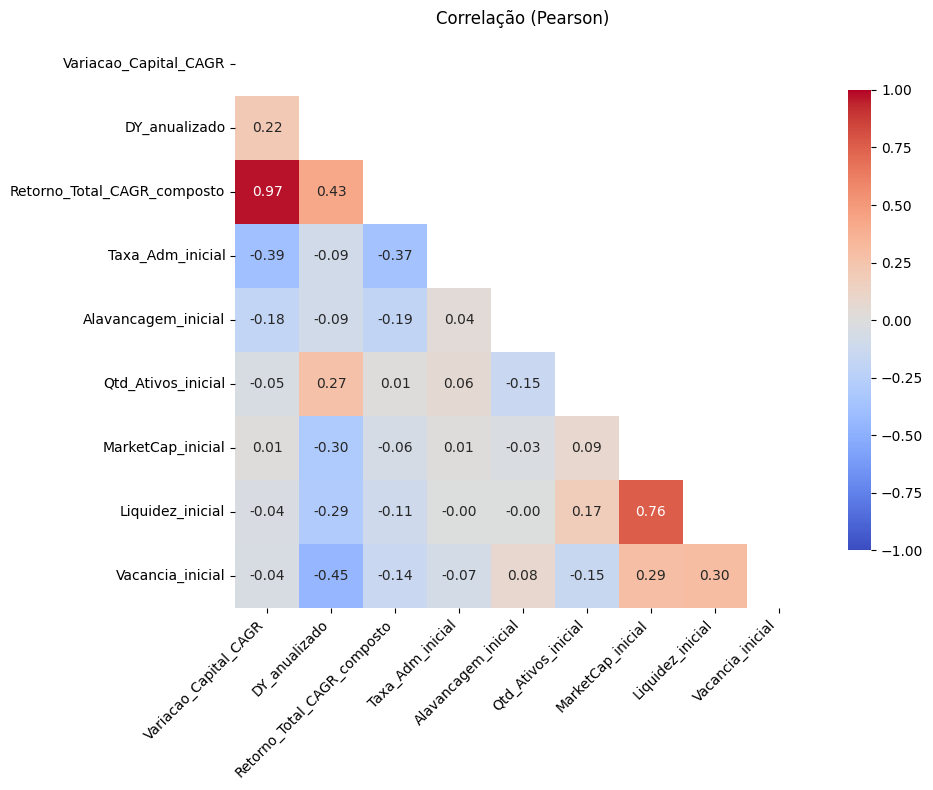

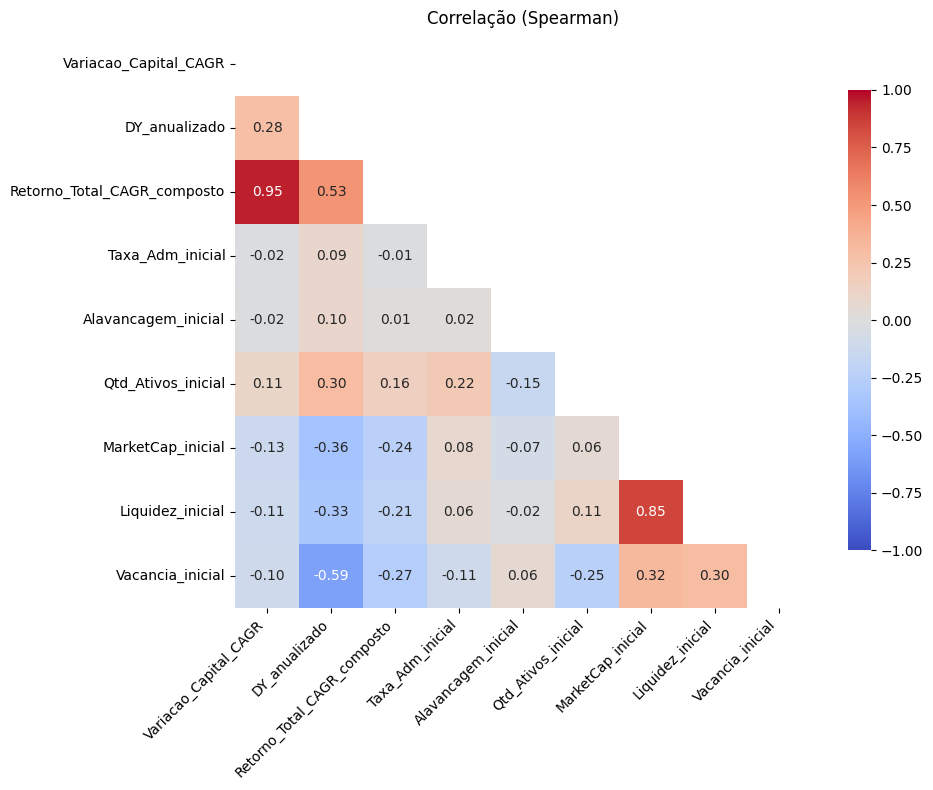

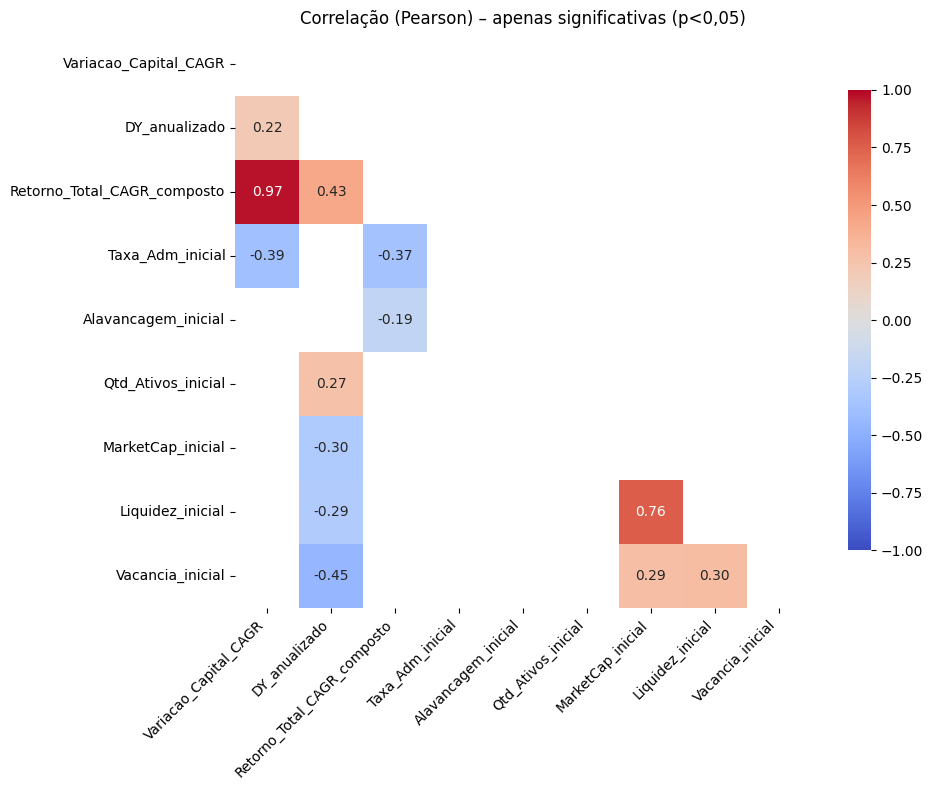


=== Gráficos - Distribuições Numéricas ===


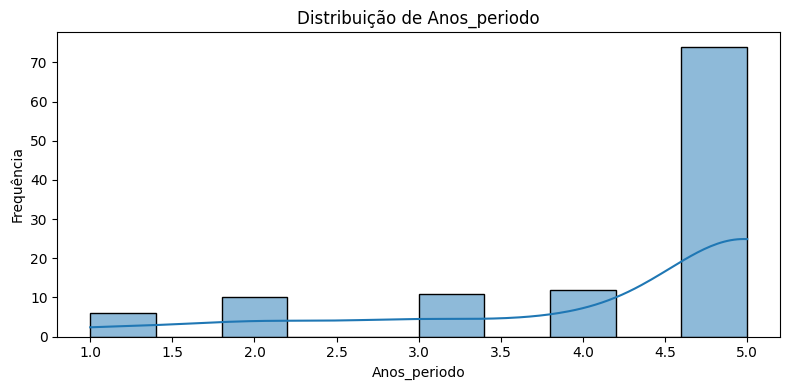

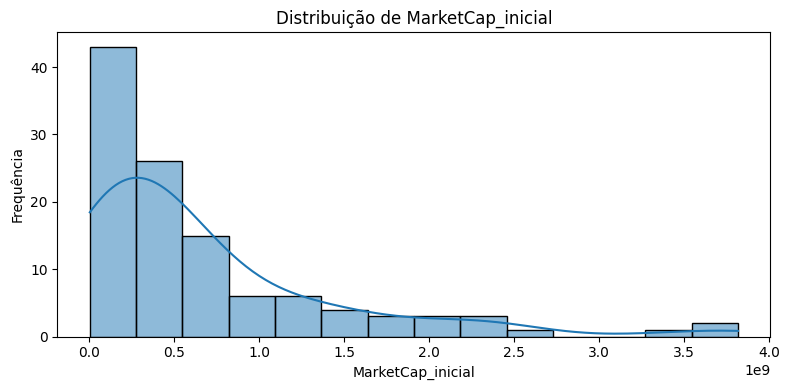

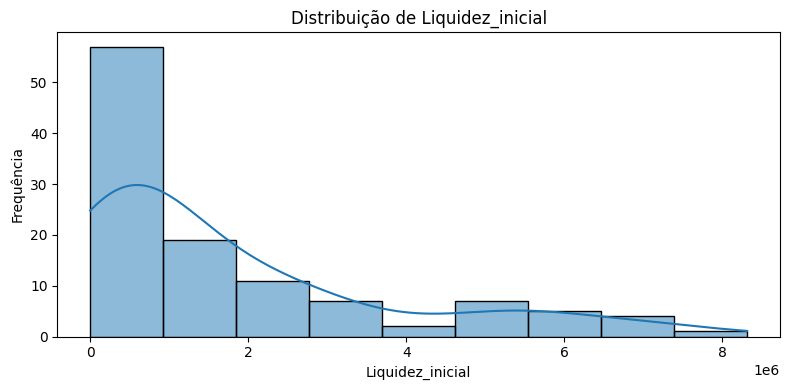

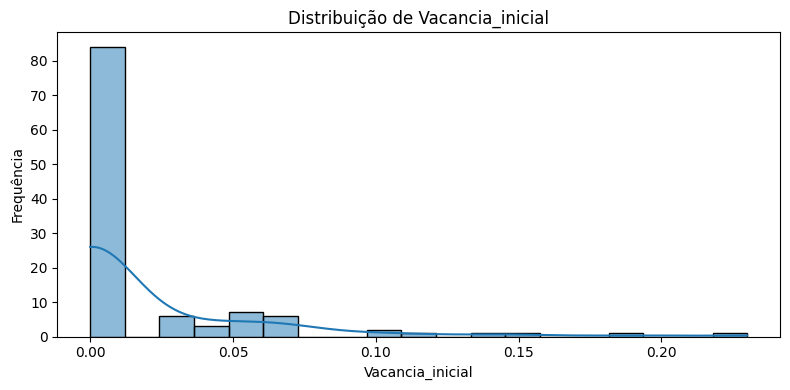

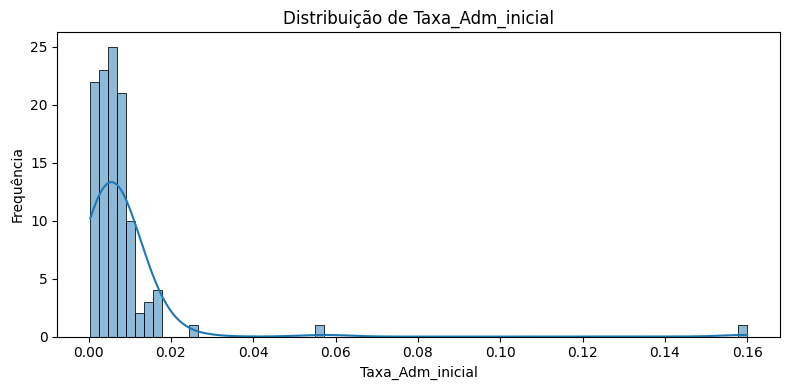

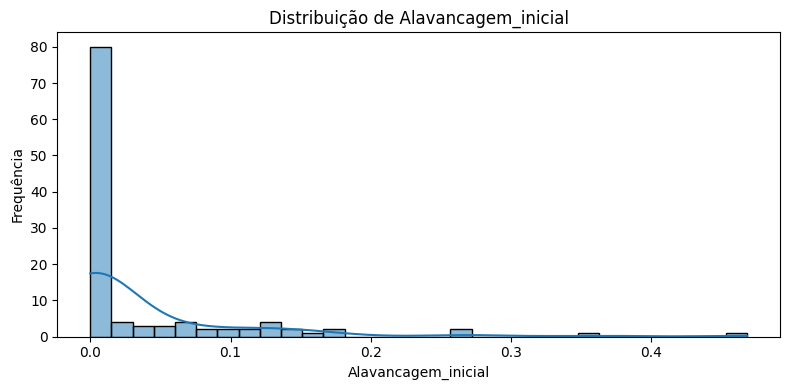

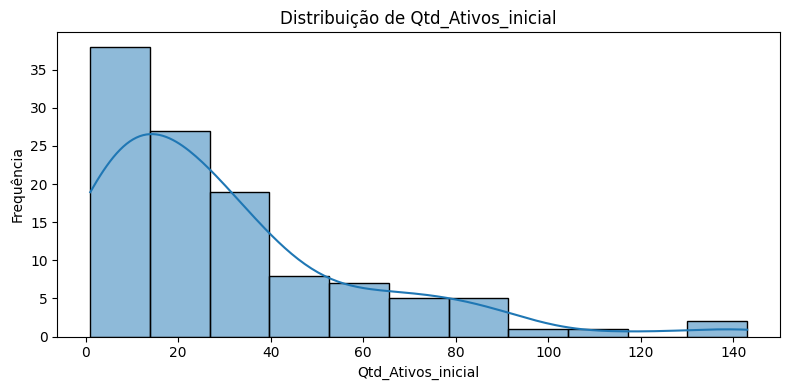

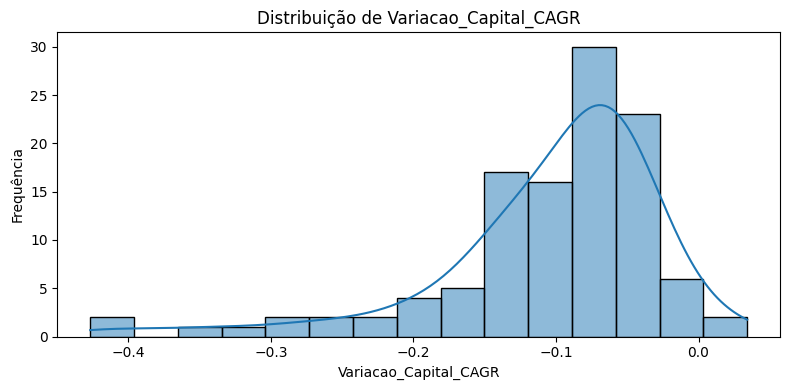

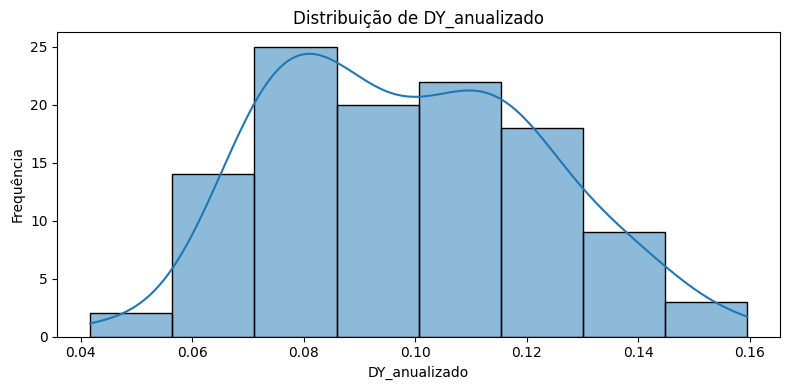

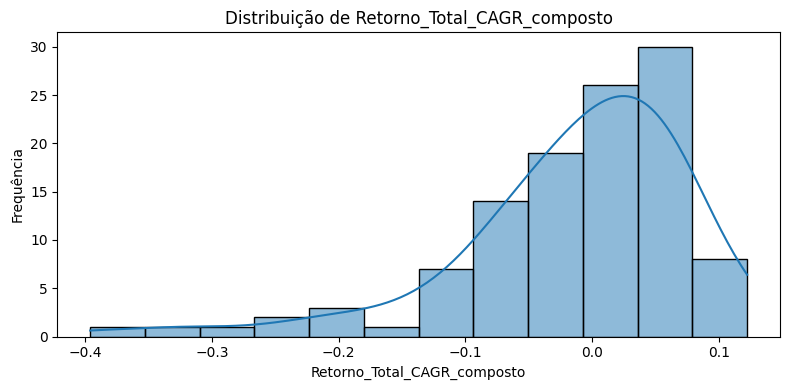

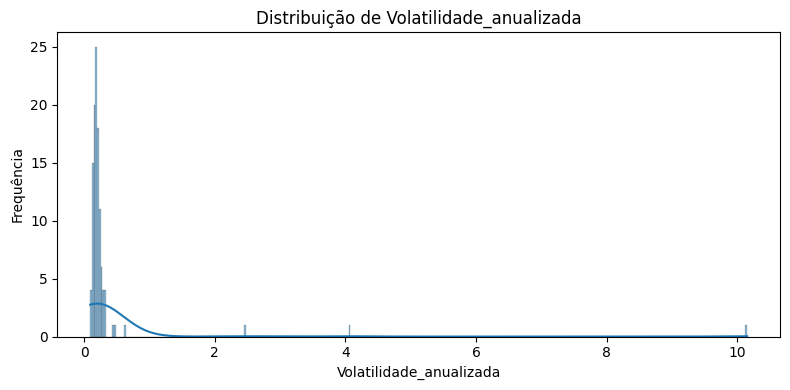

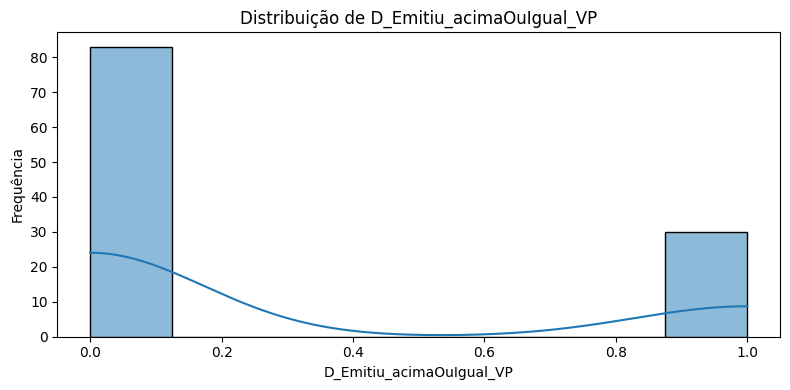

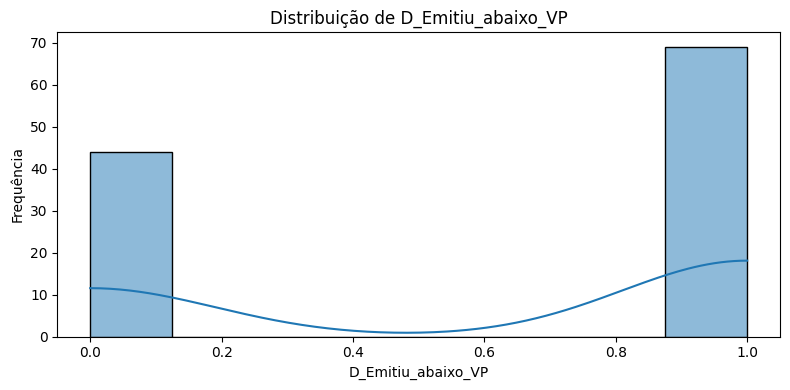


=== Gráficos - Boxplots Numéricos ===


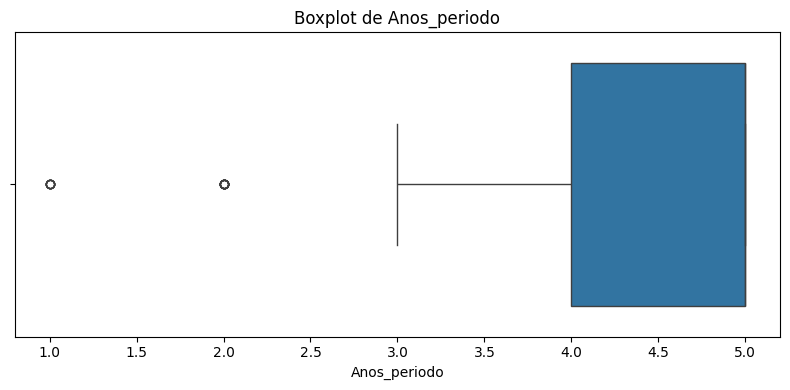

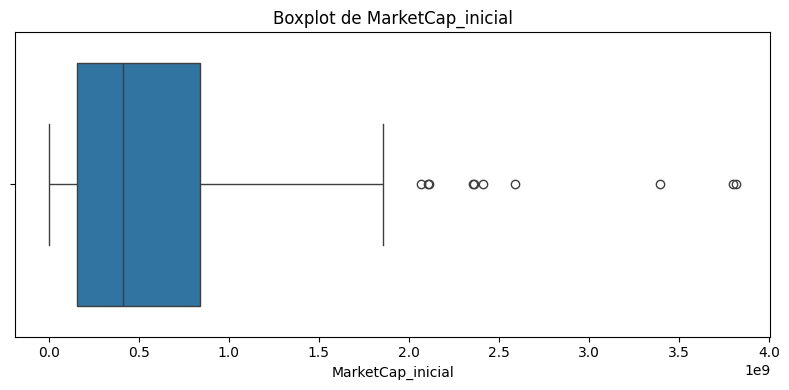

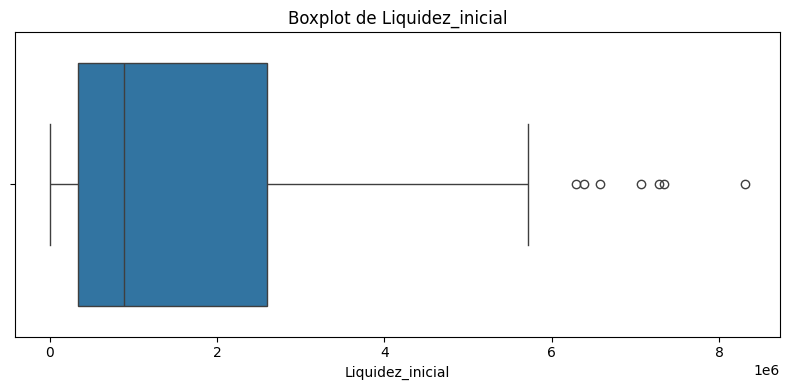

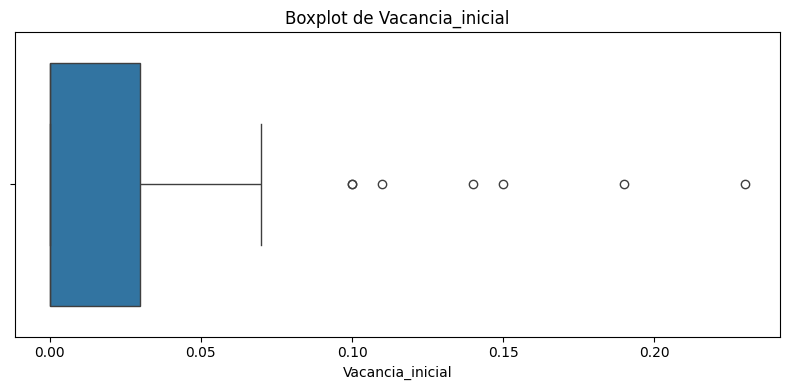

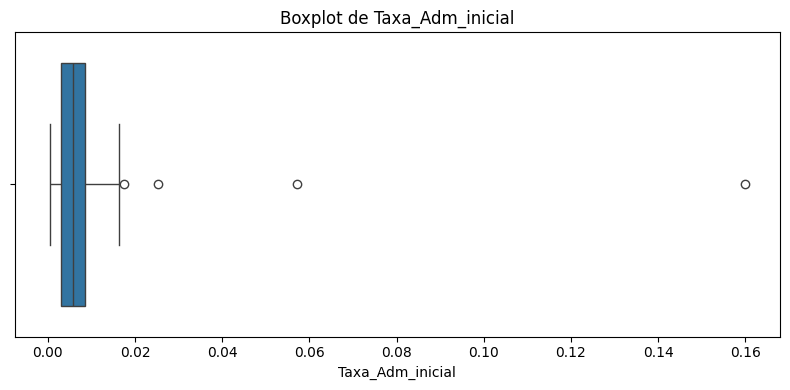

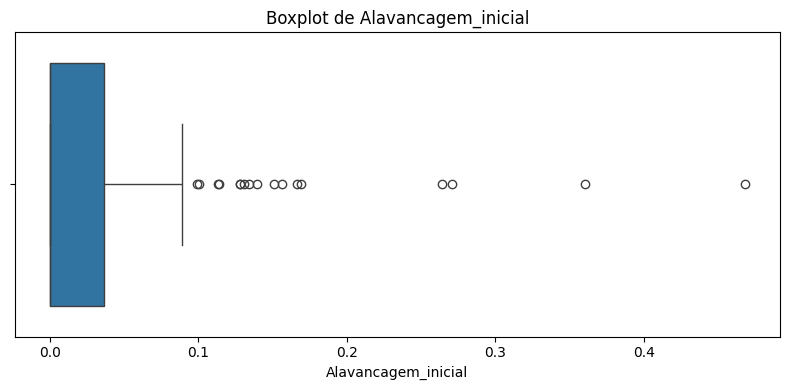

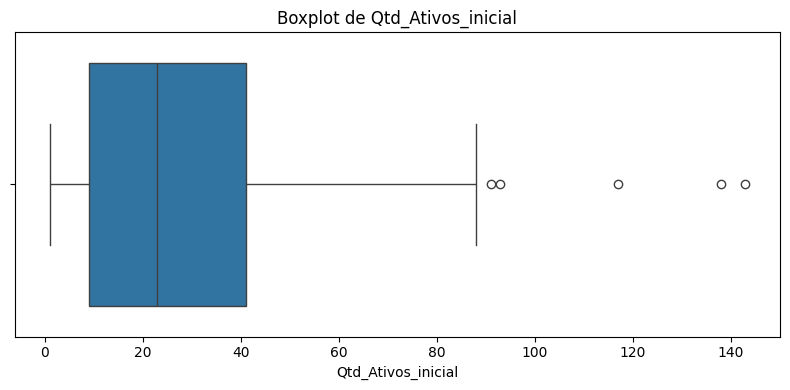

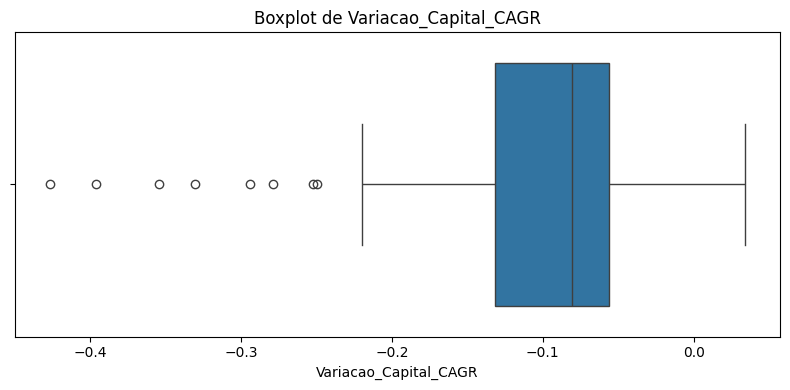

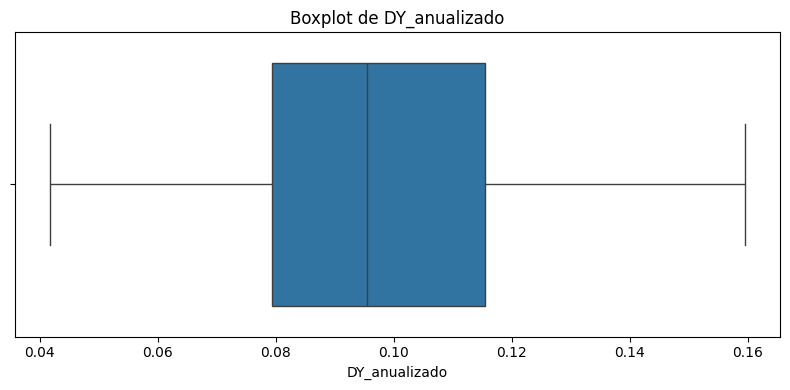

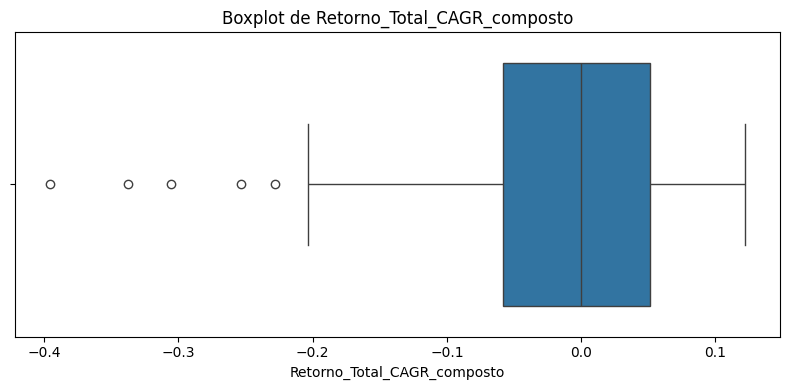

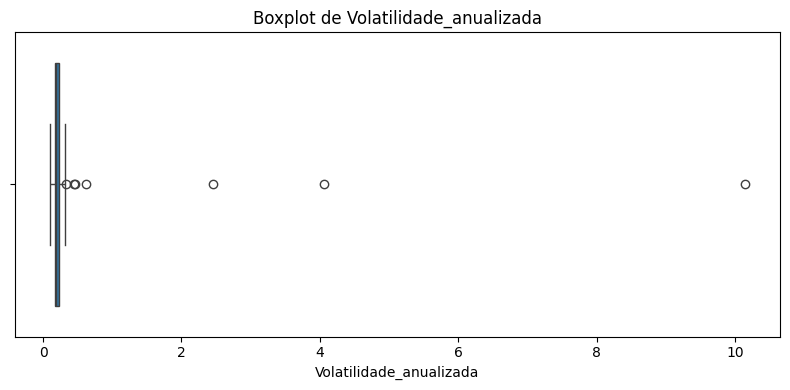

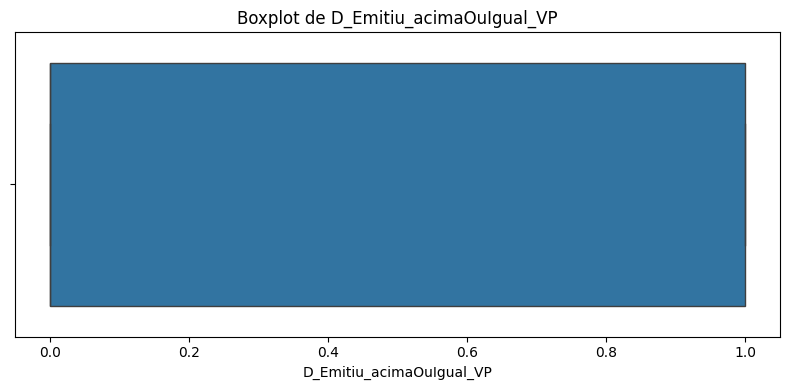

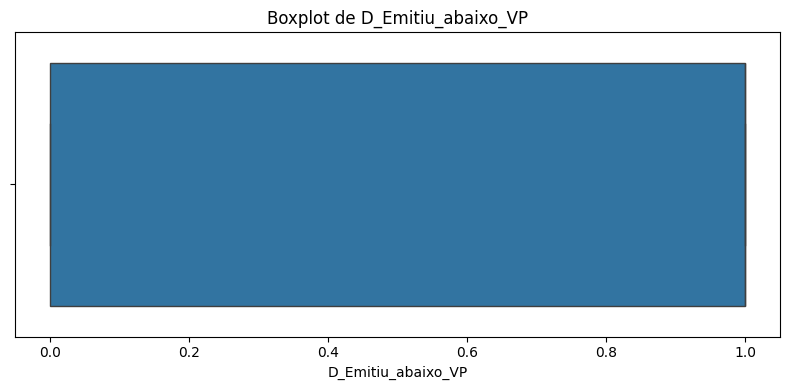


=== Gráficos - Frequência de Categóricas ===


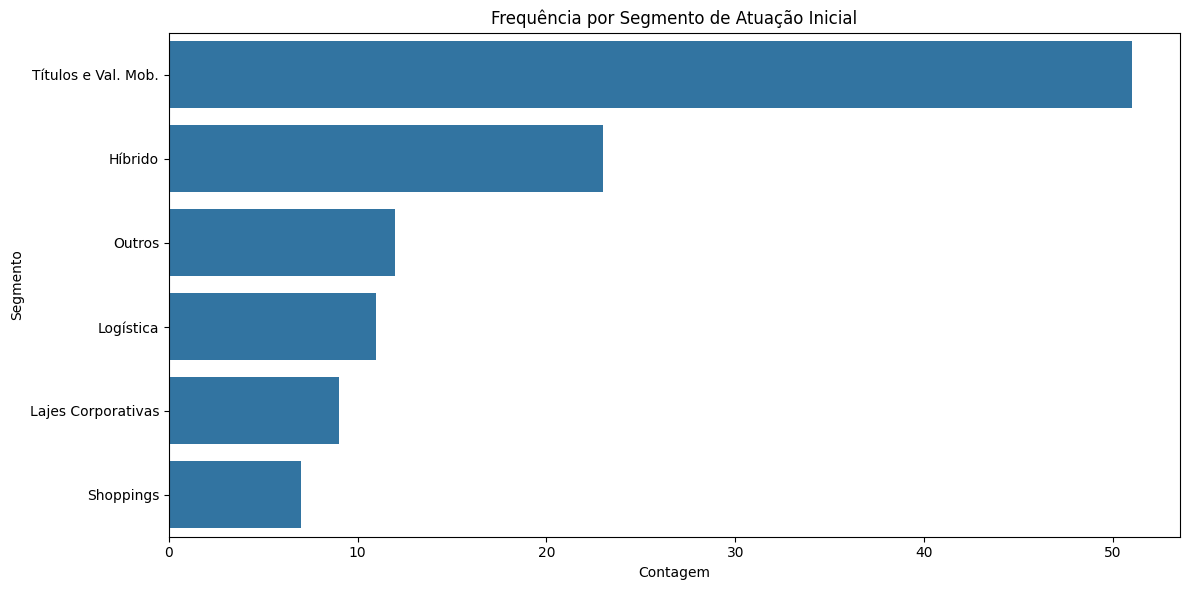

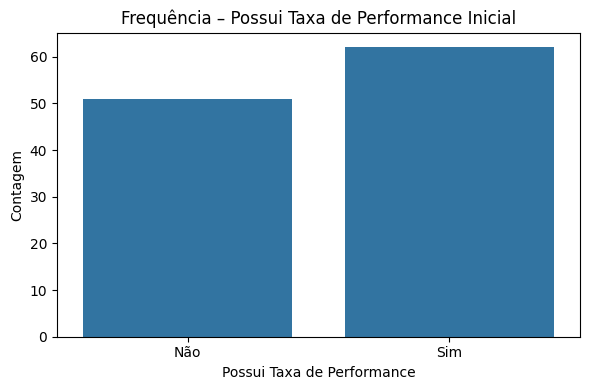

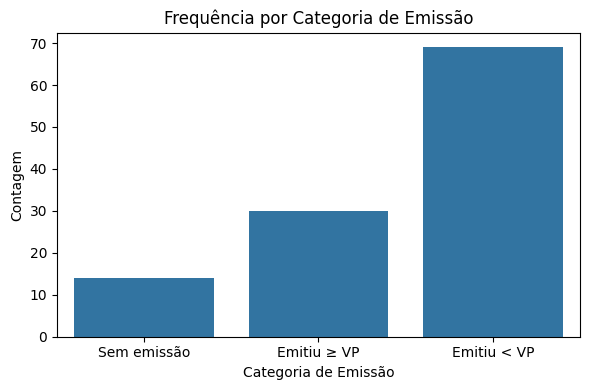


=== Gráficos Bivariados - Retornos vs Variáveis Iniciais ===


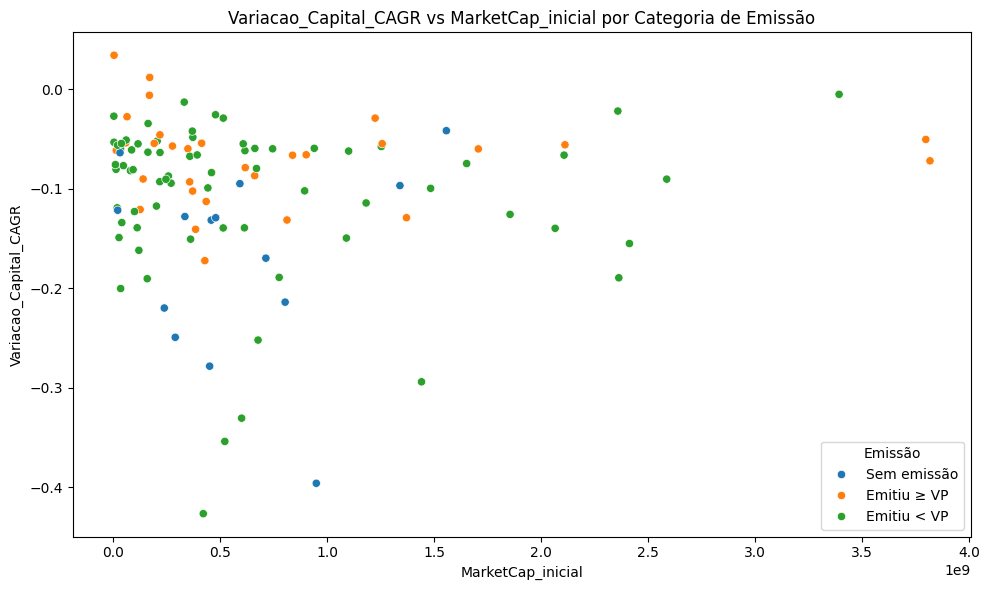

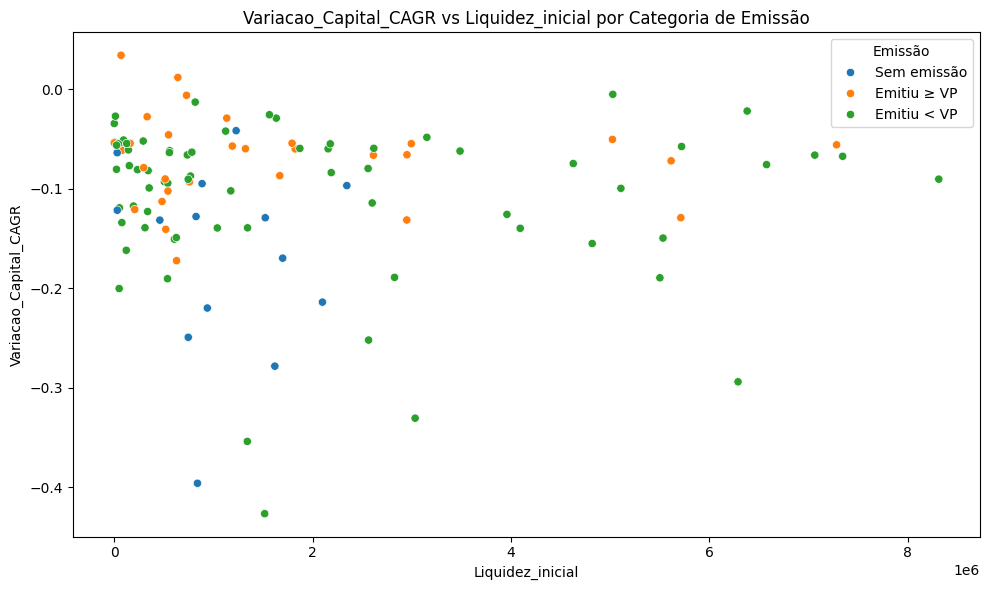

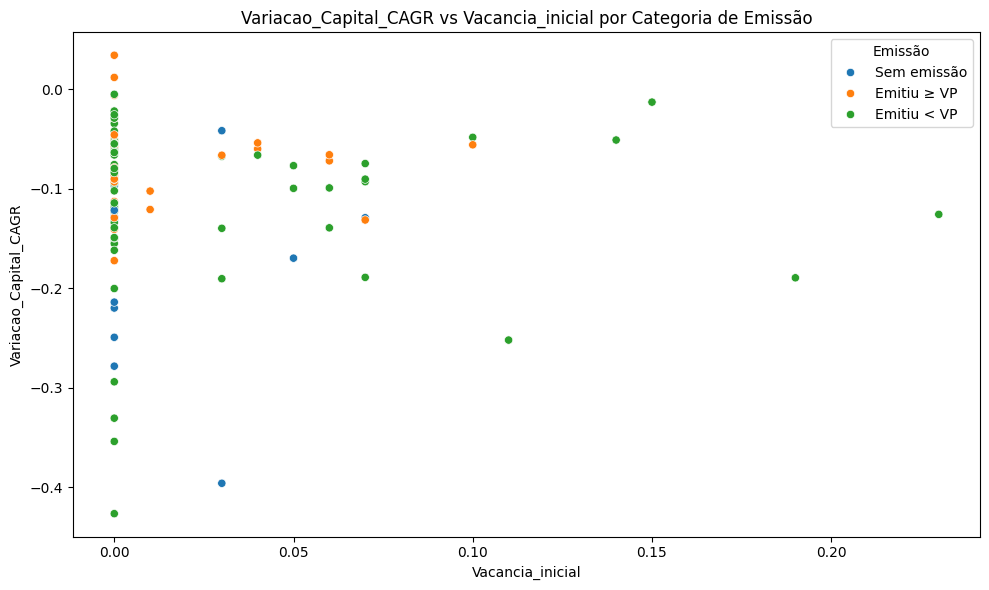

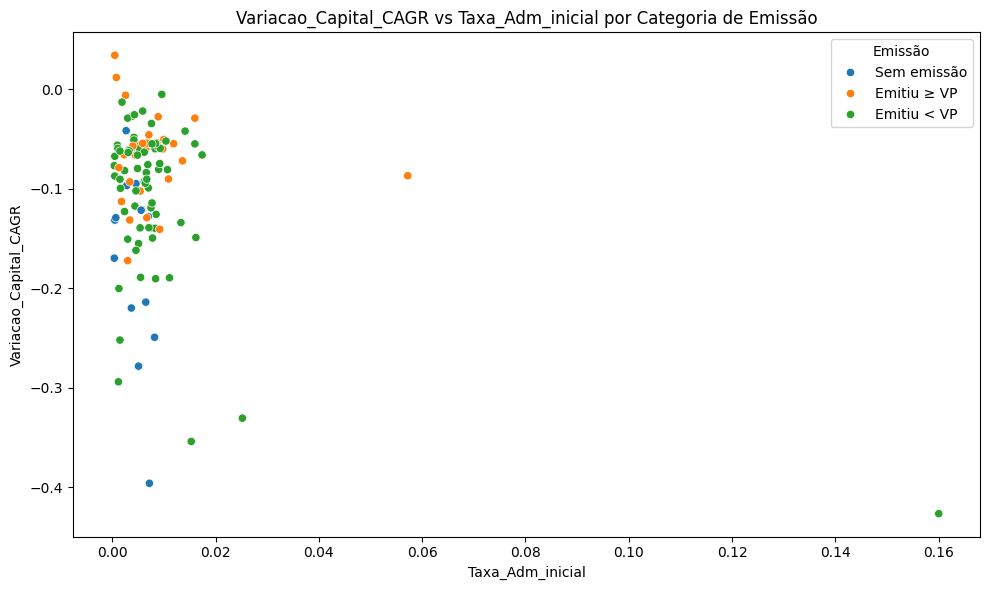

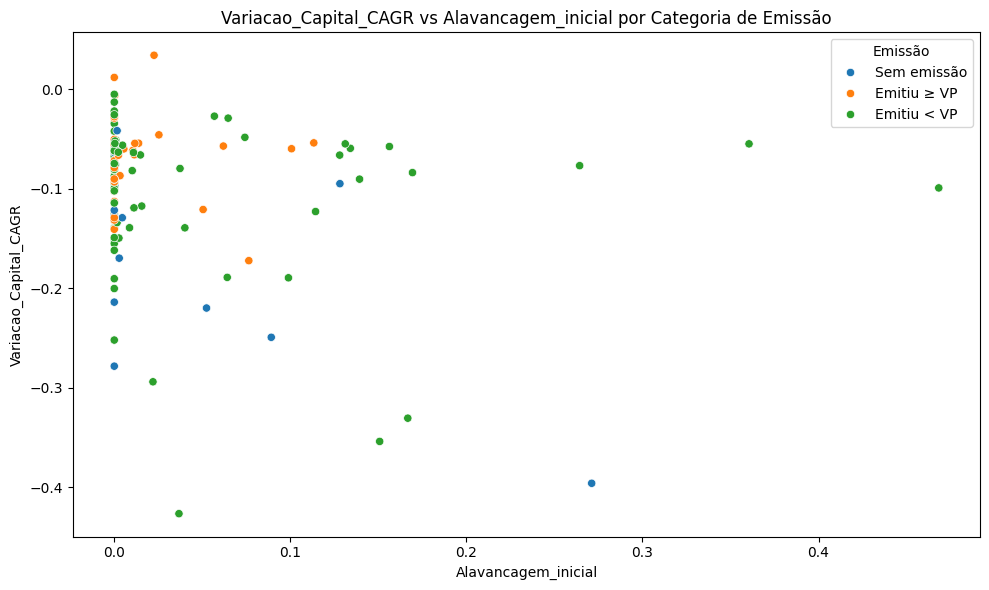

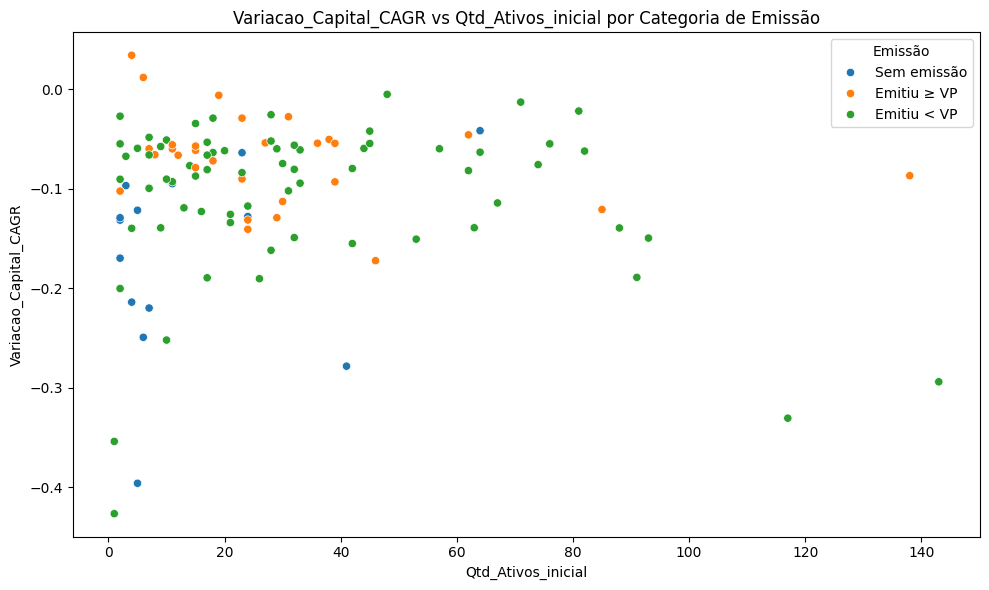

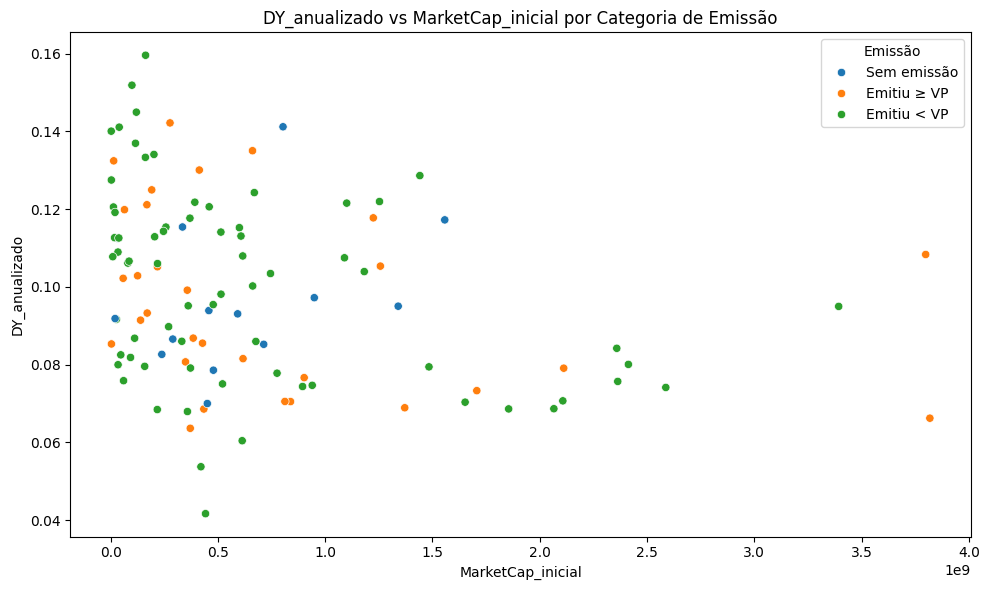

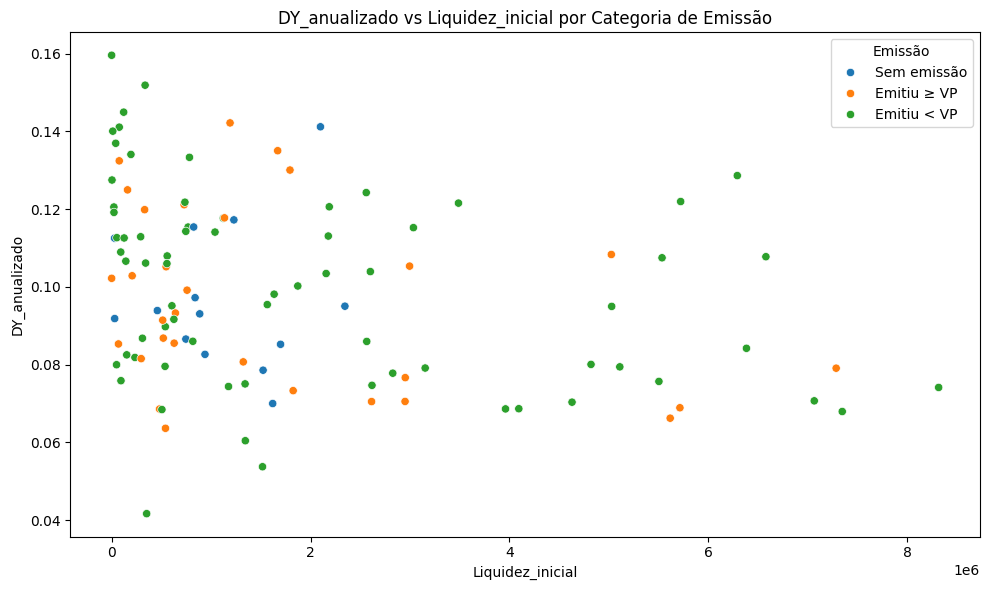

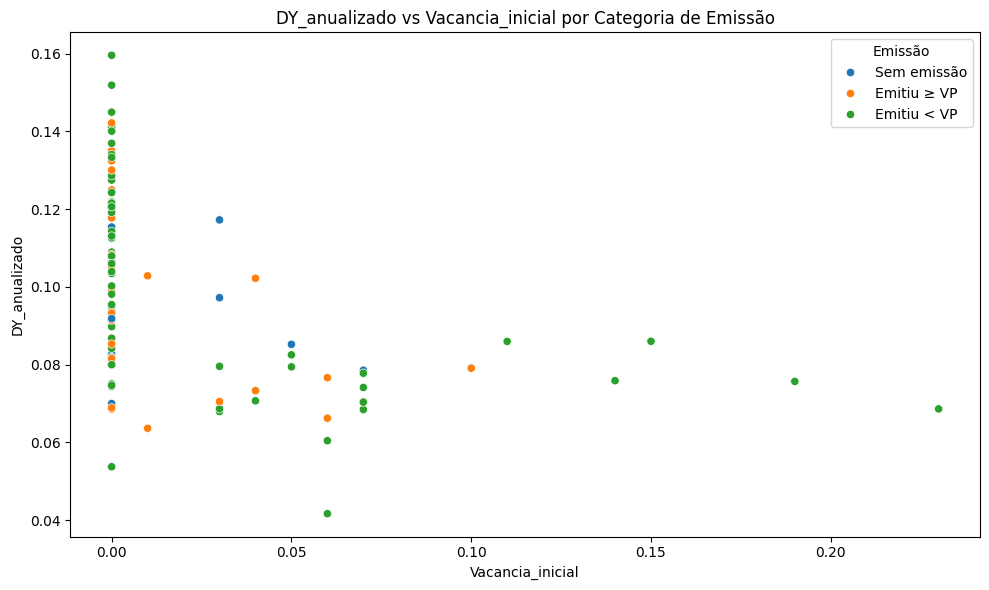

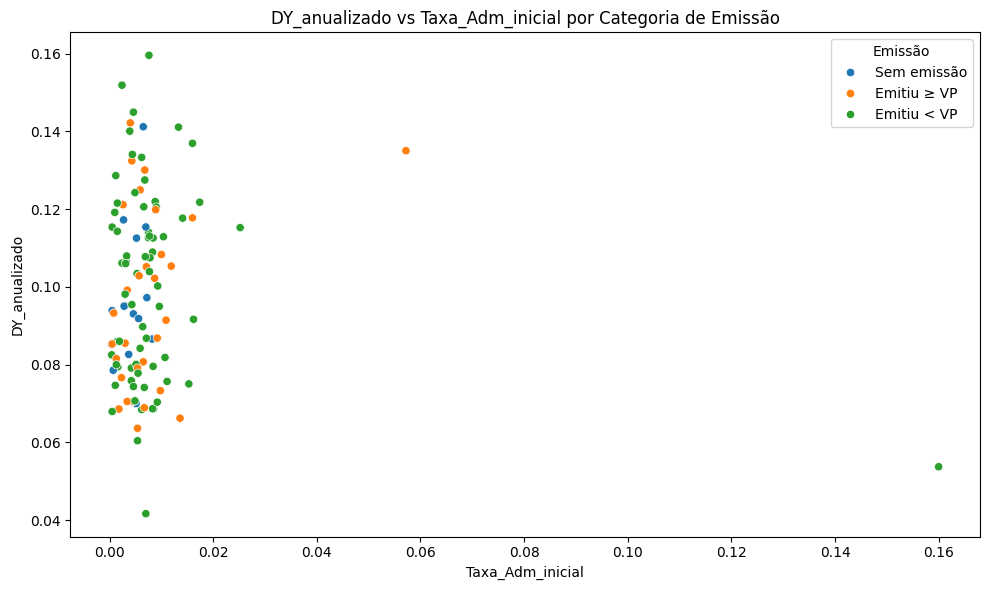

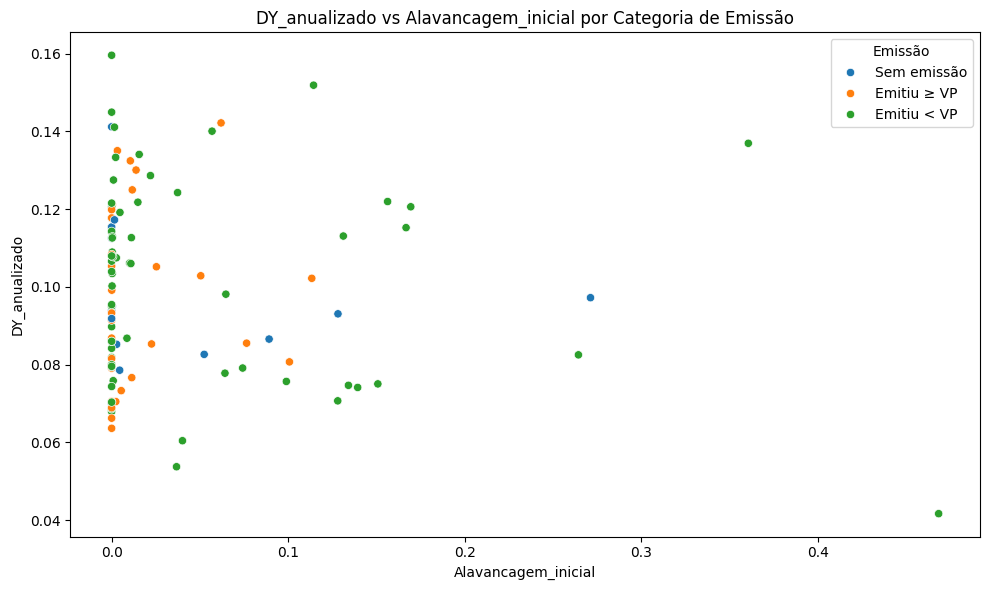

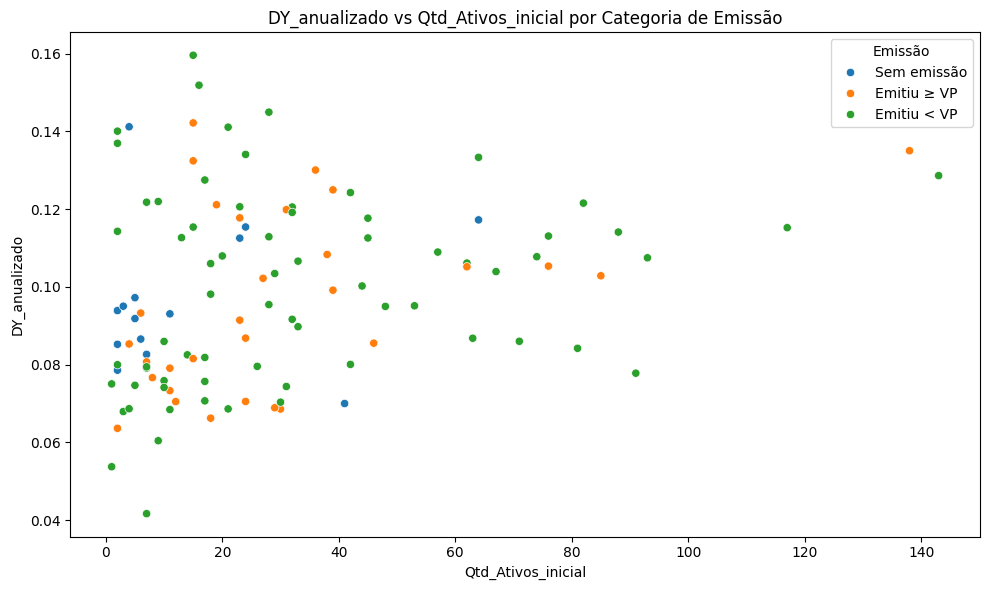

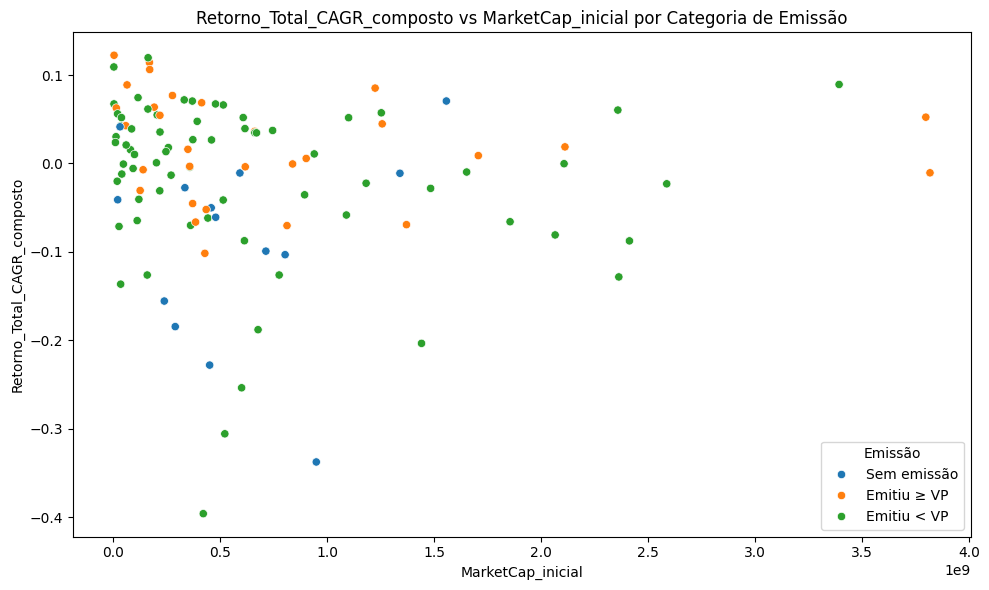

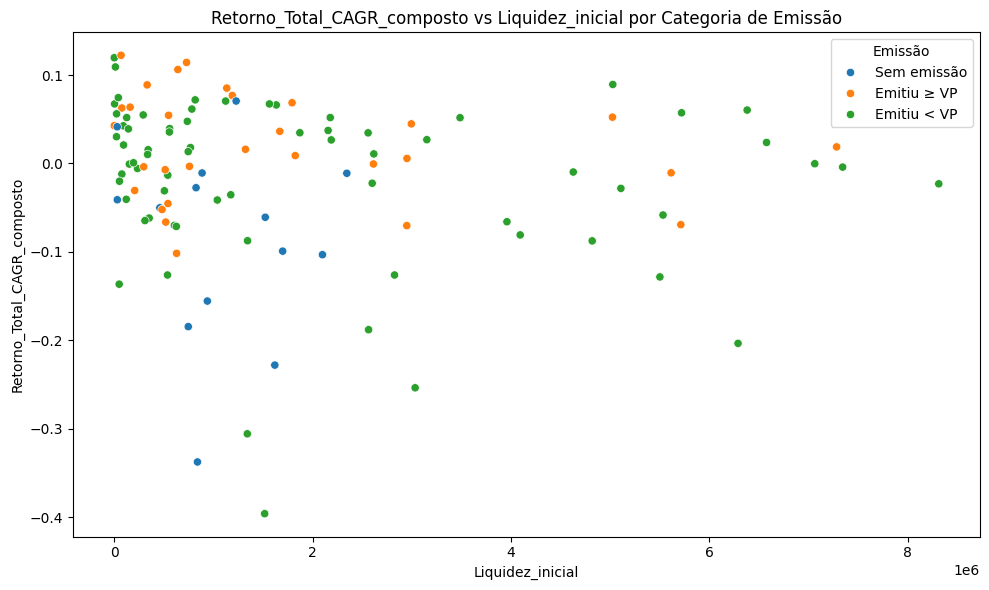

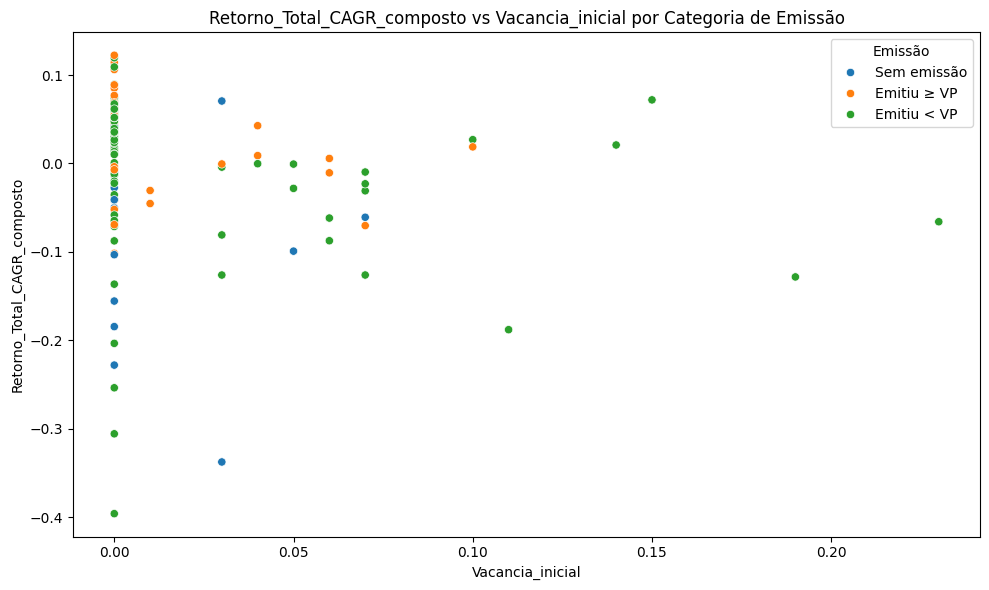

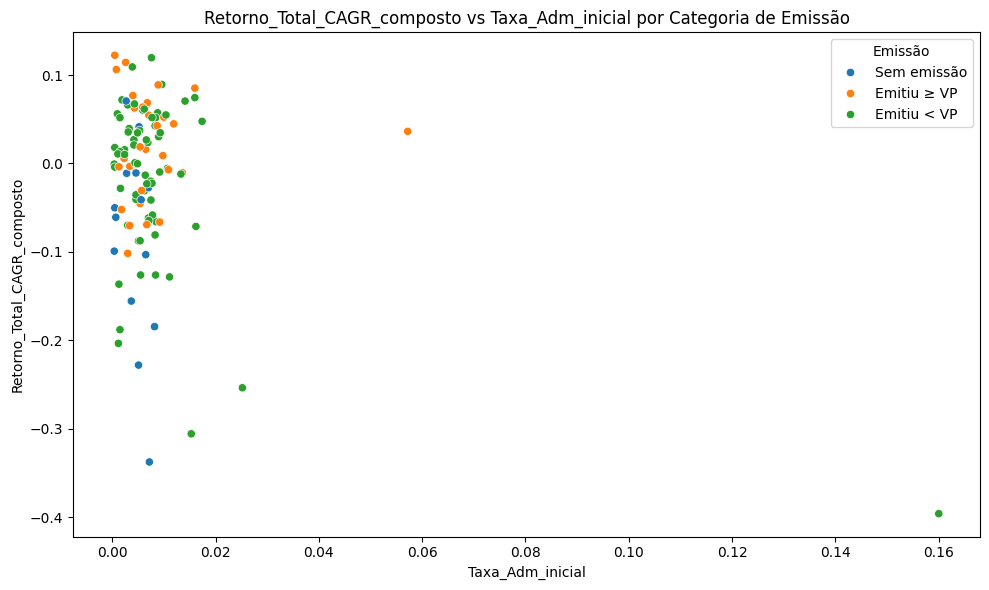

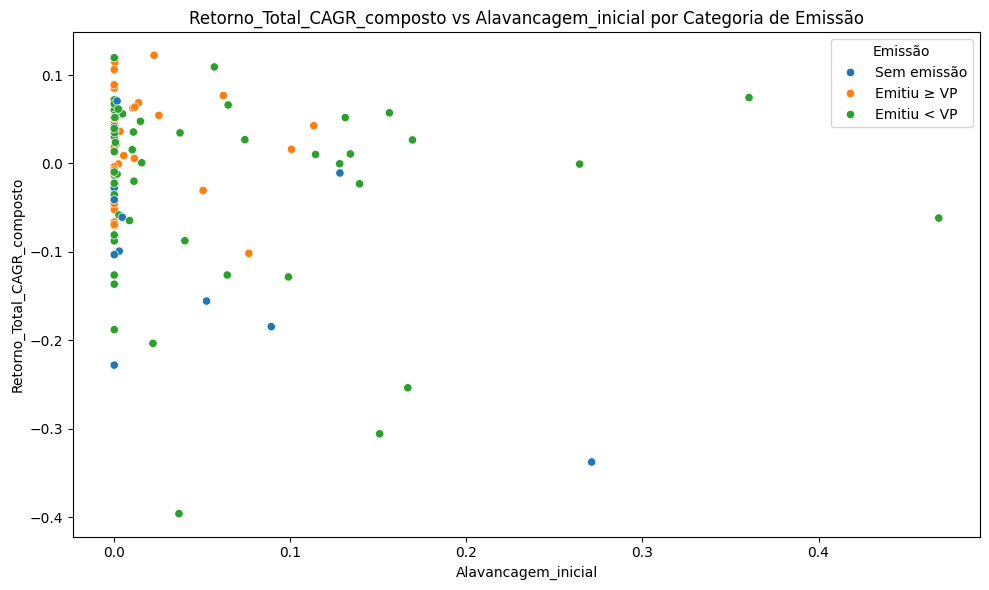

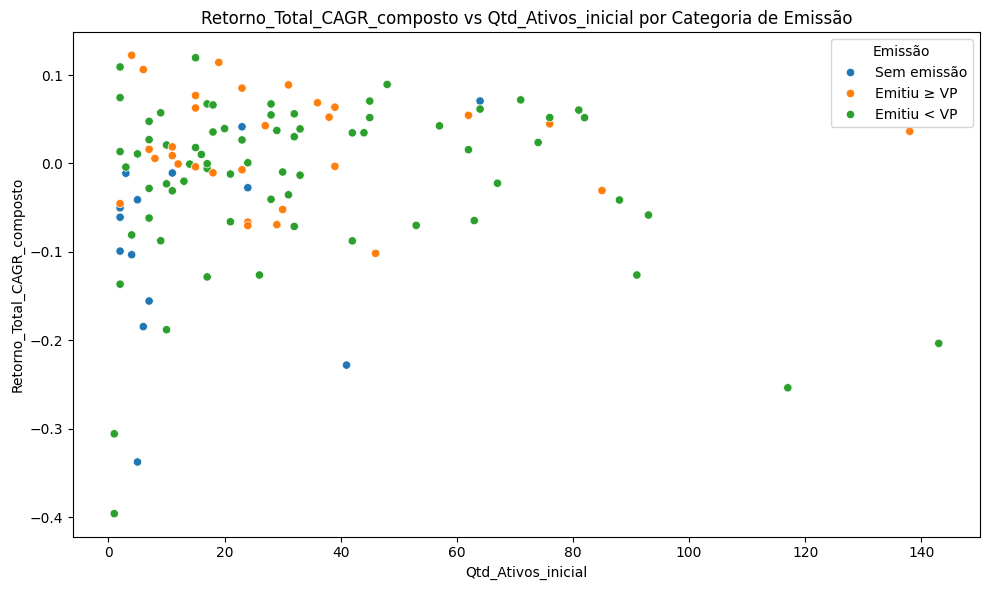

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# =========================
# 0) Ponto de partida
# =========================
df = base_canon.copy()

# Categoria de emissão (NÃO sobrescrever df depois disso!)
df['Categoria_Emissao'] = np.select(
    [
        df['D_Emitiu_acimaOuIgual_VP'] == 1,
        df['D_Emitiu_abaixo_VP'] == 1
    ],
    ['Emitiu ≥ VP', 'Emitiu < VP'],
    default='Sem emissão'
)
# ordem (opcional)
cat_order = pd.CategoricalDtype(categories=['Sem emissão','Emitiu ≥ VP','Emitiu < VP'], ordered=True)
df['Categoria_Emissao'] = df['Categoria_Emissao'].astype(cat_order)

# =========================
# 1) Tabela descritiva legível
# =========================
num_cols = [
    'Anos_periodo','MarketCap_inicial','Liquidez_inicial','Vacancia_inicial',
    'Taxa_Adm_inicial','Alavancagem_inicial','Qtd_Ativos_inicial',
    'Variacao_Capital_CAGR','DY_anualizado','Retorno_Total_CAGR_composto', 'Volatilidade_anualizada',
    'D_Emitiu_acimaOuIgual_VP','D_Emitiu_abaixo_VP'
]
num_cols = [c for c in num_cols if c in df.columns]

# Percentuais apenas para exibição
pct_cols = [
    'Vacancia_inicial','Taxa_Adm_inicial','Alavancagem_inicial',
    'Variacao_Capital_CAGR','DY_anualizado','Retorno_Total_CAGR_composto'
]
pct_cols = [c for c in pct_cols if c in df.columns]

df_disp = df[num_cols].copy()
df_disp[pct_cols] = df_disp[pct_cols] * 100

desc = df_disp.describe(percentiles=[0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99]).T
desc = desc.rename(columns={
    'min':'min','1%':'p1','5%':'p5','10%':'p10','25%':'p25','50%':'p50','75%':'p75',
    '90%':'p90','95%':'p95','99%':'p99','max':'max'
})
desc['skew'] = df_disp.skew()
desc['kurtosis'] = df_disp.kurtosis()

cols_order = ['count','mean','std','min','p1','p5','p10','p25','p50','p75','p90','p95','p99','max','skew','kurtosis']
desc = desc[cols_order]

with pd.option_context('display.float_format', '{:,.4f}'.format,
                       'display.max_rows', 200, 'display.max_columns', 100,
                       'display.width', 130):
    print("\n=== Estatísticas descritivas (%, onde indicado) ===")
    print(desc.to_string())

print("\n=== Frequência – Segmento_Atuacao_inicial ===")
if 'Segmento_Atuacao_inicial' in df.columns:
    print(df['Segmento_Atuacao_inicial'].value_counts(dropna=False).to_string())

print("\n=== Frequência – Possui_Taxa_Performance_inicial ===")
if 'Possui_Taxa_Performance_inicial' in df.columns:
    print(df['Possui_Taxa_Performance_inicial'].value_counts(dropna=False).to_string())

print("\n=== Frequência – Categoria_Emissao ===")
print(df['Categoria_Emissao'].value_counts().to_string())

# =========================
# 2) Heatmaps de correlação
# =========================
corr_vars = [
    'Variacao_Capital_CAGR','DY_anualizado','Retorno_Total_CAGR_composto',
    'Taxa_Adm_inicial','Alavancagem_inicial','Qtd_Ativos_inicial',
    'MarketCap_inicial','Liquidez_inicial','Vacancia_inicial'
]
corr_vars = [c for c in corr_vars if c in df.columns]

def corr_and_pvals(data, cols, method='pearson'):
    X = data[cols].dropna()
    C = X.corr(method=method)
    P = pd.DataFrame(np.ones_like(C), index=C.index, columns=C.columns)
    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols):
            if j <= i:
                continue
            if method == 'pearson':
                r, p = stats.pearsonr(X[c1], X[c2])
            else:
                r, p = stats.spearmanr(X[c1], X[c2])
            C.loc[c1, c2] = C.loc[c2, c1] = r
            P.loc[c1, c2] = P.loc[c2, c1] = p
    return C, P

def plot_heatmap(C, title, mask_upper=True):
    mask = np.triu(np.ones_like(C, dtype=bool)) if mask_upper else None
    plt.figure(figsize=(10, 8))
    sns.heatmap(C, mask=mask, vmin=-1, vmax=1, center=0, cmap='coolwarm',
                annot=True, fmt='.2f', square=True, cbar_kws={'shrink': .8})
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.title(title); plt.tight_layout(); plt.show()

C_pear, P_pear = corr_and_pvals(df, corr_vars, method='pearson')
plot_heatmap(C_pear, 'Correlação (Pearson)')

C_spear, P_spear = corr_and_pvals(df, corr_vars, method='spearman')
plot_heatmap(C_spear, 'Correlação (Spearman)')

# Só significativas (p<0,05) – Pearson
sig_mask = P_pear < 0.05
C_sig = C_pear.where(sig_mask)
plot_heatmap(C_sig, 'Correlação (Pearson) – apenas significativas (p<0,05)')

# =========================
# 3) Gráficos univariados
# =========================
print("\n=== Gráficos - Distribuições Numéricas ===")
for c in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df, x=c, kde=True)
    plt.title(f'Distribuição de {c}')
    plt.xlabel(c); plt.ylabel('Frequência'); plt.tight_layout()
    plt.show()

print("\n=== Gráficos - Boxplots Numéricos ===")
for c in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x=c)
    plt.title(f'Boxplot de {c}')
    plt.xlabel(c); plt.tight_layout()
    plt.show()

print("\n=== Gráficos - Frequência de Categóricas ===")
if 'Segmento_Atuacao_inicial' in df.columns:
    plt.figure(figsize=(12,6))
    sns.countplot(data=df, y='Segmento_Atuacao_inicial',
                  order=df['Segmento_Atuacao_inicial'].value_counts().index)
    plt.title('Frequência por Segmento de Atuação Inicial')
    plt.xlabel('Contagem'); plt.ylabel('Segmento'); plt.tight_layout(); plt.show()

if 'Possui_Taxa_Performance_inicial' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x='Possui_Taxa_Performance_inicial')
    plt.title('Frequência – Possui Taxa de Performance Inicial')
    plt.xlabel('Possui Taxa de Performance'); plt.ylabel('Contagem'); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Categoria_Emissao')
plt.title('Frequência por Categoria de Emissão')
plt.xlabel('Categoria de Emissão'); plt.ylabel('Contagem'); plt.tight_layout(); plt.show()

# =========================
# 4) Gráficos bivariados
# =========================
print("\n=== Gráficos Bivariados - Retornos vs Variáveis Iniciais ===")
retorno_vars = ['Variacao_Capital_CAGR','DY_anualizado','Retorno_Total_CAGR_composto']
initial_vars = [
    'MarketCap_inicial','Liquidez_inicial','Vacancia_inicial',
    'Taxa_Adm_inicial','Alavancagem_inicial','Qtd_Ativos_inicial'
]
for ret_v in retorno_vars:
    for init_v in initial_vars:
        if ret_v in df.columns and init_v in df.columns:
            plt.figure(figsize=(10,6))
            sns.scatterplot(data=df, x=init_v, y=ret_v, hue='Categoria_Emissao')
            plt.title(f'{ret_v} vs {init_v} por Categoria de Emissão')
            plt.xlabel(init_v); plt.ylabel(ret_v)
            plt.legend(title='Emissão'); plt.tight_layout(); plt.show()


In [ ]:
desc

,count,mean,std,min,p1,p5,p10,p25,p50,p75,p90,p95,p99,max,skew,kurtosis
Anos_periodo,113.0,4.221239e+00,1.244520e+00,1.000000e+00,1.000000e+00,1.600000e+00,2.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,-1.392773,0.613723
MarketCap_inicial,113.0,6.762544e+08,7.899862e+08,3.006408e+06,3.665696e+06,1.700705e+07,3.457133e+07,1.590570e+08,4.135320e+08,8.386697e+08,1.696047e+09,2.361153e+09,3.750444e+09,3.818610e+09,2.023795,4.400885
Liquidez_inicial,113.0,1.815087e+06,2.041757e+06,9.480000e+02,1.434000e+03,2.797380e+04,7.097300e+04,3.373020e+05,8.863480e+05,2.601437e+06,5.423550e+06,6.326845e+06,7.337615e+06,8.313964e+06,1.405783,1.048206
Vacancia_inicial,113.0,1.902655e+00,4.053139e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,7.000000e+00,1.000000e+01,1.852000e+01,2.300000e+01,2.846008,9.359715
Taxa_Adm_inicial,113.0,7.987611e-01,1.578288e+00,4.000000e-02,4.120000e-02,6.200000e-02,1.300000e-01,3.100000e-01,5.700000e-01,8.400000e-01,1.174000e+00,1.600000e+00,5.336000e+00,1.600000e+01,8.395307,78.897236
Alavancagem_inicial,113.0,3.561863e+00,7.522082e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.390000e-02,3.674600e+00,1.281326e+01,1.604474e+01,3.498045e+01,4.683000e+01,3.233527,12.714179
Qtd_Ativos_inicial,113.0,3.023894e+01,2.911562e+01,1.000000e+00,1.120000e+00,2.000000e+00,3.200000e+00,9.000000e+00,2.300000e+01,4.100000e+01,7.340000e+01,8.620000e+01,1.354800e+02,1.430000e+02,1.636371,2.888545
Variacao_Capital_CAGR,113.0,-1.038787e+01,7.879395e+00,-4.268011e+01,-3.912002e+01,-2.627517e+01,-1.903696e+01,-1.315259e+01,-8.090558e+00,-5.633286e+00,-3.595615e+00,-2.421023e+00,9.782877e-01,3.411451e+00,-1.818817,4.207850
DY_anualizado,113.0,9.869039e+00,2.384420e+00,4.167611e+00,5.454704e+00,6.824834e+00,7.007012e+00,7.943437e+00,9.544511e+00,1.154039e+01,1.319437e+01,1.404623e+01,1.510421e+01,1.595730e+01,0.251166,-0.583855
Retorno_Total_CAGR_composto,113.0,-1.503623e+00,9.298862e+00,-3.959953e+01,-3.337297e+01,-1.941556e+01,-1.261468e+01,-5.830800e+00,-2.906933e-02,5.175153e+00,7.059738e+00,8.903341e+00,1.189157e+01,1.223484e+01,-1.580532,3.391586


In [ ]:
df['Segmento_Atuacao_inicial'].value_counts(dropna=False)

,count
Segmento_Atuacao_inicial,
Títulos e Val. Mob.,51
Híbrido,23
Outros,12
Logística,11
Lajes Corporativas,9
Shoppings,7


In [ ]:
df[df['Categoria_Emissao']=="Sem emissão"]['Segmento_Atuacao_inicial'].value_counts(dropna=False)

,count
Segmento_Atuacao_inicial,
Títulos e Val. Mob.,4
Lajes Corporativas,3
Híbrido,3
Logística,2
Outros,2


In [ ]:
df[df['Categoria_Emissao']=="Emitiu ≥ VP"]['Segmento_Atuacao_inicial'].value_counts(dropna=False)

,count
Segmento_Atuacao_inicial,
Títulos e Val. Mob.,16
Logística,5
Híbrido,4
Outros,3
Lajes Corporativas,1
Shoppings,1


In [ ]:
df[df['Categoria_Emissao']=="Emitiu < VP"]['Segmento_Atuacao_inicial'].value_counts(dropna=False)

,count
Segmento_Atuacao_inicial,
Títulos e Val. Mob.,31
Híbrido,16
Outros,7
Shoppings,6
Lajes Corporativas,5
Logística,4


In [ ]:
df['Categoria_Emissao'].value_counts()

,count
Categoria_Emissao,
Emitiu < VP,69
Emitiu ≥ VP,30
Sem emissão,14


In [ ]:
df['Possui_Taxa_Performance_inicial'].value_counts(dropna=False)

,count
Possui_Taxa_Performance_inicial,
Sim,62
Não,51


In [ ]:
df[df['Categoria_Emissao']=="Sem emissão"]['Possui_Taxa_Performance_inicial'].value_counts(dropna=False)

,count
Possui_Taxa_Performance_inicial,
Não,11
Sim,3


In [ ]:
df[df['Categoria_Emissao']=="Emitiu ≥ VP"]['Possui_Taxa_Performance_inicial'].value_counts(dropna=False)

,count
Possui_Taxa_Performance_inicial,
Sim,16
Não,14


In [ ]:
df[df['Categoria_Emissao']=="Emitiu < VP"]['Possui_Taxa_Performance_inicial'].value_counts(dropna=False)

,count
Possui_Taxa_Performance_inicial,
Sim,43
Não,26


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Ticker                           113 non-null    object  
 1   Ano_inicial                      113 non-null    int64   
 2   Ano_final                        113 non-null    int64   
 3   Anos_periodo                     113 non-null    float64 
 4   MarketCap_inicial                113 non-null    int64   
 5   Liquidez_inicial                 113 non-null    int64   
 6   Vacancia_inicial                 113 non-null    float64 
 7   Taxa_Adm_inicial                 113 non-null    float64 
 8   Possui_Taxa_Performance_inicial  113 non-null    object  
 9   Alavancagem_inicial              113 non-null    float64 
 10  Segmento_Atuacao_inicial         113 non-null    object  
 11  Qtd_Ativos_inicial               113 non-null    int64   
 12  Variacao

In [ ]:
# Média e desvio-padrão das variáveis contínuas por Categoria_Emissao

import pandas as pd

# 1) Liste explicitamente as variáveis contínuas que você quer na tabela
continuous_cols = [
    'Anos_periodo', 'MarketCap_inicial', 'Liquidez_inicial', 'Vacancia_inicial',
    'Taxa_Adm_inicial', 'Alavancagem_inicial', 'Qtd_Ativos_inicial',
    'Variacao_Capital_CAGR', 'DY_anualizado', 'Retorno_Total_CAGR_composto',
    'Volatilidade_anualizada'
]
continuous_cols = [c for c in continuous_cols if c in df.columns]  # garante que existem

# (opcional) Se quiser exibir percentuais em % ao invés de proporção:
percent_cols = [
    'Vacancia_inicial','Taxa_Adm_inicial','Alavancagem_inicial',
    'Variacao_Capital_CAGR','DY_anualizado','Retorno_Total_CAGR_composto',
    'Volatilidade_anualizada'
]
df2 = df.copy()
for c in percent_cols:
    if c in df2.columns:
        df2[c] = df2[c] * 100

# 2) Gera a tabela em formato "wide" (categorias nas linhas; cada variável com colunas mean/std)
ordem = ['Sem emissão','Emitiu ≥ VP','Emitiu < VP']  # ajuste se necessário
tabela_mean_std = (df2
    .groupby('Categoria_Emissao')[continuous_cols]
    .agg(['mean','std'])
    .round(3)
    .reindex(ordem)
)

# Se preferir colunas simples (flatten):
tabela_mean_std.columns = [f'{var}__{stat}' for var, stat in tabela_mean_std.columns]
# Ex.: colunas como 'DY_anualizado__mean' e 'DY_anualizado__std'

print(tabela_mean_std)

# 3) (Opcional) Versão "arrumada" (long/tidy) — útil para Word/LaTeX:
#    Cada linha = (Categoria_Emissao, Variavel, Média, DP)
g = (df2.groupby('Categoria_Emissao')[continuous_cols]
       .agg(['mean','std'])
       .round(3))
tabela_tidy = (g
    .stack(level=0)                      # empilha nível das variáveis
    .reset_index()
    .rename(columns={'level_1':'Variavel', 'mean':'Media', 'std':'DP'})
)

print(tabela_tidy)

# 4) (Opcional) Exporta para Excel
# with pd.ExcelWriter('tabela_mean_std_por_emissao.xlsx', engine='xlsxwriter') as wb:
#     tabela_mean_std.to_excel(wb, sheet_name='wide')
#     tabela_tidy.to_excel(wb, sheet_name='tidy', index=False)


                   Anos_periodo__mean  Anos_periodo__std  \
Categoria_Emissao                                          
Sem emissão                     2.714              1.637   
Emitiu ≥ VP                     4.167              1.177   
Emitiu < VP                     4.551              0.932   

                   MarketCap_inicial__mean  MarketCap_inicial__std  \
Categoria_Emissao                                                    
Sem emissão                   5.901620e+08            4.516871e+08   
Emitiu ≥ VP                   7.765586e+08            9.755094e+08   
Emitiu < VP                   6.501118e+08            7.592062e+08   

                   Liquidez_inicial__mean  Liquidez_inicial__std  \
Categoria_Emissao                                                  
Sem emissão                   1091247.786             702153.418   
Emitiu ≥ VP                   1686708.433            1927105.830   
Emitiu < VP                   2017769.855            2243063.267   

       

/tmp/ipython-input-3944698884.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Categoria_Emissao')[continuous_cols]
/tmp/ipython-input-3944698884.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = (df2.groupby('Categoria_Emissao')[continuous_cols]
/tmp/ipython-input-3944698884.py:46: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)                      # empilha nível 

In [ ]:
tabela_mean_std.transpose()

Categoria_Emissao,Sem emissão,Emitiu ≥ VP,Emitiu < VP
Anos_periodo__mean,2.714000e+00,4.167000e+00,4.551000e+00
Anos_periodo__std,1.637000e+00,1.177000e+00,9.320000e-01
MarketCap_inicial__mean,5.901620e+08,7.765586e+08,6.501118e+08
MarketCap_inicial__std,4.516871e+08,9.755094e+08,7.592062e+08
Liquidez_inicial__mean,1.091248e+06,1.686708e+06,2.017770e+06
Liquidez_inicial__std,7.021534e+05,1.927106e+06,2.243063e+06
Vacancia_inicial__mean,1.286000e+00,1.400000e+00,2.246000e+00
Vacancia_inicial__std,2.301000e+00,2.660000e+00,4.766000e+00
Taxa_Adm_inicial__mean,4.300000e-01,7.920000e-01,8.770000e-01
Taxa_Adm_inicial__std,2.580000e-01,1.007000e+00,1.904000e+00


Comentários tabela com estatísticas descritivas e matriz de correlação de pearson

# Modelo 1 - Variação de Capital BaseLine

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import numpy.linalg as LA

# --- ponto de partida ---
df = base_canon.copy()

# ---------------------------
# 1) Dummies com categorias de referência
# ---------------------------
# Segmento: referência "Outros"
seg_vals = df['Segmento_Atuacao_inicial'].astype(str).fillna('Outros').unique().tolist()
if 'Outros' in seg_vals:
    seg_cats = ['Outros'] + sorted([v for v in seg_vals if v != 'Outros'])
else:
    seg_cats = sorted(seg_vals)  # fallback se "Outros" não existir
df['Segmento_Atuacao_inicial'] = pd.Categorical(df['Segmento_Atuacao_inicial'], categories=seg_cats, ordered=True)
seg_dum = pd.get_dummies(df['Segmento_Atuacao_inicial'],
                         prefix='Segmento_Atuacao_inicial',
                         drop_first=True,  # dropa a 1ª categoria da ordem -> "Outros"
                         dtype=np.int8)

# Possui taxa performance: referência "Não"
perf_cats = ['Não', 'Sim']
df['Possui_Taxa_Performance_inicial'] = pd.Categorical(df['Possui_Taxa_Performance_inicial'], categories=perf_cats, ordered=True)
perf_dum = pd.get_dummies(df['Possui_Taxa_Performance_inicial'],
                          prefix='Possui_Taxa_Performance_inicial',
                          drop_first=True,  # dropa "Não"
                          dtype=np.int8)
# renomear para ficar limpo (terá só uma coluna "Sim")
perf_dum.columns = ['Possui_Taxa_Performance_inicial_Sim']

# ---------------------------
# 2) Montar X e Y (baseline linear)
# ---------------------------
y = pd.to_numeric(df['Variacao_Capital_CAGR'], errors='coerce')

X_core = df[['MarketCap_inicial','Liquidez_inicial','Taxa_Adm_inicial',
             'Alavancagem_inicial','Qtd_Ativos_inicial', 'Vacancia_inicial',
             'D_Emitiu_acimaOuIgual_VP','D_Emitiu_abaixo_VP']].copy()

# garantir numéricos
for c in X_core.columns:
    X_core[c] = pd.to_numeric(X_core[c], errors='coerce')

# juntar dummies
X = pd.concat([X_core, perf_dum, seg_dum], axis=1)

# alinhar e remover NAs
data = pd.concat([y, X], axis=1).dropna()
y_fit = data.iloc[:, 0]
X_fit = data.iloc[:, 1:]

# constante
X_fit = sm.add_constant(X_fit, has_constant='add')

# ---------------------------
# 3) Estimar OLS (HC3) e imprimir
# ---------------------------
model_vc_baseline_hc3 = sm.OLS(y_fit, X_fit).fit(cov_type='HC3')
print("\n=== Regressão 1 — Variacao_Capital_CAGR (Baseline, HC3) ===")
print(model_vc_baseline_hc3.summary())

# Infos auxiliares
print(f"\nN observações: {int(model_vc_baseline_hc3.nobs)}")
print(f"Condition Number: {LA.cond(model_vc_baseline_hc3.model.exog):.1f}")
print("\nReferências: Segmento = 'Outros'; Possui_Taxa_Performance = 'Não'")



=== Regressão 1 — Variacao_Capital_CAGR (Baseline, HC3) ===
                              OLS Regression Results                             
Dep. Variable:     Variacao_Capital_CAGR   R-squared:                       0.384
Model:                               OLS   Adj. R-squared:                  0.296
Method:                    Least Squares   F-statistic:                     2.021
Date:                   Sun, 12 Oct 2025   Prob (F-statistic):             0.0300
Time:                           16:49:18   Log-Likelihood:                 154.68
No. Observations:                    113   AIC:                            -279.4
Df Residuals:                         98   BIC:                            -238.5
Df Model:                             14                                         
Covariance Type:                     HC3                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
------

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 12
  warnings.warn('covariance of constraints does not have full '


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, acorr_breusch_godfrey, linear_reset
from statsmodels.stats.stattools import jarque_bera, omni_normtest, durbin_watson
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor

# === 0) Assume que você já tem y_fit (pd.Series) e X_fit (pd.DataFrame com const) ===
# Se não tiver, ajuste aqui. Ex.: y_fit = df['Variacao_Capital_CAGR']; X_fit = sm.add_constant(...)

# === 1) Reestime um modelo "não robusto" para os testes de especificação ===
model_nr = sm.OLS(y_fit, X_fit).fit()          # não robusto (para diagnósticos)
model_hc3 = sm.OLS(y_fit, X_fit).fit(cov_type='HC3')  # robusto (para relatar no TCC, se quiser)

# === 2) Heterocedasticidade ===
bp_LM, bp_pLM, bp_F, bp_pF = het_breuschpagan(model_nr.resid, model_nr.model.exog)
w_LM, w_pLM, w_F, w_pF     = het_white(model_nr.resid, model_nr.model.exog)

# === 3) Autocorrelação (lag 1 e 2) ===
dw = durbin_watson(model_nr.resid)
bg1 = acorr_breusch_godfrey(model_nr, nlags=1)  # (LM, pval, F, pval)
bg2 = acorr_breusch_godfrey(model_nr, nlags=2)

# === 4) Normalidade dos resíduos ===
jb_stat, jb_p, skew, kurt = jarque_bera(model_nr.resid)
omni_stat, omni_p = omni_normtest(model_nr.resid)

# === 5) Especificação (Ramsey RESET, potência 2) ===
reset_res = linear_reset(model_nr, power=2, use_f=True)  # F-teste
reset_p = float(reset_res.pvalue)

# === 6) Colinearidade: VIF e Condition Number ===
# VIF: remova a constante
cols_vif = [c for c in X_fit.columns if c.lower() != 'const']
vif_df = pd.DataFrame({
    'variavel': cols_vif,
    'VIF': [variance_inflation_factor(X_fit[cols_vif].to_numpy(), i) for i in range(len(cols_vif))]
}).sort_values('VIF', ascending=False)
cond_no = np.linalg.cond(model_nr.model.exog)

# === 7) Influência: Cook’s D, leverage, resíduos estudantis externos ===
infl = OLSInfluence(model_nr)
cooks_d, _ = infl.cooks_distance
lev = infl.hat_matrix_diag
stud = infl.resid_studentized_external

df_infl = pd.DataFrame({
    'cooks_d': cooks_d,
    'leverage': lev,
    'stud_resid': stud
}, index=X_fit.index)

# limiares
n = int(model_nr.nobs)
k = int(model_nr.df_model) + 1  # nº regressores excl. const? statsmodels: df_model não inclui a const. Ajuste k_total:
k_total = model_nr.model.exog.shape[1]          # com constante
cook_thr = 4 / n
lev_thr = 2 * k_total / n
stud_thr = 3

infl_flags = df_infl[(df_infl['cooks_d'] > cook_thr) | (df_infl['leverage'] > lev_thr) | (df_infl['stud_resid'].abs() > stud_thr)]
infl_top = df_infl.sort_values('cooks_d', ascending=False).head(10)

# === 8) Impressão resumida (“ação rápida”) ===
print("=== Pressupostos OLS – ação rápida ===")
print(f"BP (F) pval:                      {bp_pF:.6f}")
print(f"White (F) pval:                   {w_pF:.6f}")
print(f"Durbin-Watson:                    {dw:.6f}")
print(f"Breusch-Godfrey lag1 pval:        {bg1[1]:.6f}")
print(f"Breusch-Godfrey lag2 pval:        {bg2[1]:.6f}")
print(f"Jarque-Bera pval:                 {jb_p:.6f}")
print(f"Omnibus pval:                     {omni_p:.6f}")
print(f"RESET (F) pval:                   {reset_p:.6f}")
print(f"Condition Number:                 {cond_no:.3f}")
print(f"k (nº regressores, c/const):      {k_total:.0f}")
print(f"n (amostra):                      {n:.0f}")

print("\n--- Regras de bolso ---")
print("• Homocedasticidade: p(BP/White) > 0.05 → OK; se < 0.05 use HC3/WLS.")
print("• Independência: DW≈2 e p(BG)>0.05 → OK; se < 0.05, use HAC (Newey-West) ou modele a dependência.")
print("• Normalidade: p(JB/Omni)>0.05 → OK; se < 0.05, confie em HC3/HAC (TCL ajuda).")
print("• Especificação: p(RESET)>0.05 → forma funcional OK; se < 0.05, reespecificar (não-linearidades/interações).")
print("• Colinearidade: VIF>10 ou Cond. Nº>30 ligam alerta; >100 é crítico.")

print("\nTop VIFs:")
print(vif_df.head(10).to_string(index=False))

print("\nObs. potencialmente influentes (limiares: Cook>%.3f, leverage>%.3f, |stud_resid|>%d):" % (cook_thr, lev_thr, stud_thr))
print(infl_top.to_string())

# ver as linhas problemáticas com suas chaves:
id_cols = [c for c in ['Ticker'] if c in base_canon.columns]
print("\nLinhas sinalizadas (qualquer critério):")
print(base_canon.loc[infl_flags.index, id_cols].join(infl_flags).sort_values('cooks_d', ascending=False).head(20).to_string())




=== Pressupostos OLS – ação rápida ===
BP (F) pval:                      0.058208
White (F) pval:                   0.001019
Durbin-Watson:                    2.115855
Breusch-Godfrey lag1 pval:        0.493676
Breusch-Godfrey lag2 pval:        0.778538
Jarque-Bera pval:                 0.000170
Omnibus pval:                     0.000480
RESET (F) pval:                   0.001203
Condition Number:                 67981111633.853
k (nº regressores, c/const):      15
n (amostra):                      113

--- Regras de bolso ---
• Homocedasticidade: p(BP/White) > 0.05 → OK; se < 0.05 use HC3/WLS.
• Independência: DW≈2 e p(BG)>0.05 → OK; se < 0.05, use HAC (Newey-West) ou modele a dependência.
• Normalidade: p(JB/Omni)>0.05 → OK; se < 0.05, confie em HC3/HAC (TCL ajuda).
• Especificação: p(RESET)>0.05 → forma funcional OK; se < 0.05, reespecificar (não-linearidades/interações).
• Colinearidade: VIF>10 ou Cond. Nº>30 ligam alerta; >100 é crítico.

Top VIFs:
                                

In [ ]:
from scipy.stats import norm
import numpy as np

# 1) Teste via t_test (usa a covariância robusta do modelo HC3)
tres = model_vc_baseline_hc3.t_test('D_Emitiu_acimaOuIgual_VP - D_Emitiu_abaixo_VP = 0')
z_two_sided = float(tres.tvalue)           # estatística (aprox. z)
p_two_sided = float(tres.pvalue)           # p bicaudal

# 2) Diferença pontual, SE robusta, p-valor únicaudal (H1: diff > 0)
b = model_vc_baseline_hc3.params
V = model_vc_baseline_hc3.cov_params()

diff = float(b['D_Emitiu_acimaOuIgual_VP'] - b['D_Emitiu_abaixo_VP'])
se   = float(np.sqrt(
    V.loc['D_Emitiu_acimaOuIgual_VP','D_Emitiu_acimaOuIgual_VP']
  + V.loc['D_Emitiu_abaixo_VP','D_Emitiu_abaixo_VP']
  - 2*V.loc['D_Emitiu_acimaOuIgual_VP','D_Emitiu_abaixo_VP']
))
z    = diff / se if se > 0 else np.nan
p_one_sided = float(norm.sf(z))            # P(Z >= z) — únicaudal à direita
ci95 = (diff - 1.96*se, diff + 1.96*se)

print("\n=== Contraste: β(≥VP) − β(<VP) ===")
print(f"Δ = {diff:.4f}  SE(HC3) = {se:.4f}  z = {z:.2f}")
print(f"p-valor (2 caudas, statsmodels) = {p_two_sided:.4f}")
print(f"p-valor (1 cauda, H1: ≥VP > <VP) = {p_one_sided:.4f}")
print(f"IC95% (HC3) = ({ci95[0]:.4f}, {ci95[1]:.4f})")

alpha = 0.05
decisao = "REJEITA H0 (evidência de ≥VP > <VP)" if p_one_sided < alpha else "NÃO REJEITA H0"
print(f"Decisão (α={alpha:.2f}, únicaudal): {decisao}")



=== Contraste: β(≥VP) − β(<VP) ===
Δ = 0.0208  SE(HC3) = 0.0155  z = 1.34
p-valor (2 caudas, statsmodels) = 0.1807
p-valor (1 cauda, H1: ≥VP > <VP) = 0.0903
IC95% (HC3) = (-0.0096, 0.0512)
Decisão (α=0.05, únicaudal): NÃO REJEITA H0


/tmp/ipython-input-551241147.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z_two_sided = float(tres.tvalue)           # estatística (aprox. z)


**Regressão 2 — Variacao_Capital_CAGR (Ajustada, HC3)**

In [ ]:
# =========================
# Regressão 2 — Ajustada (HC3) + Diagnósticos
# =========================
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, acorr_breusch_godfrey, linear_reset
from statsmodels.stats.stattools import jarque_bera, omni_normtest, durbin_watson
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
import numpy.linalg as LA

df = base_canon.copy()

# ---------------------------
# 0) Helpers
# ---------------------------
def zscore(x):
    x = pd.to_numeric(x, errors='coerce')
    mu = x.mean()
    sd = x.std(ddof=0)
    sd = sd if sd and not np.isclose(sd, 0) else 1.0
    return (x - mu) / sd

def log1p_clip(x):
    # clipa valores negativos para 0 (esperado não ter negativos nas contínuas)
    return np.log1p(pd.to_numeric(x, errors='coerce').clip(lower=0))

# ---------------------------
# 1) Transformações (log1p + z)
# ---------------------------
df['z_log_MC']   = zscore(log1p_clip(df['MarketCap_inicial']))
df['z_log_LIQ']  = zscore(log1p_clip(df['Liquidez_inicial']))
df['TaxaAdm_log1p_z']   = zscore(log1p_clip(df['Taxa_Adm_inicial']))
df['QtdAtivos_log1p_z'] = zscore(log1p_clip(df['Qtd_Ativos_inicial']))
df['Vacancia_log1p_z'] = zscore(log1p_clip(df['Vacancia_inicial']))

# ---------------------------
# 2) Alavancagem two-part
# ---------------------------
raw_alav = pd.to_numeric(df['Alavancagem_inicial'], errors='coerce').fillna(0.0)
df['Alav_pos'] = (raw_alav > 0).astype(np.int8)

alav_level = np.where(raw_alav > 0, np.log1p(raw_alav), 0.0)
mask_pos = raw_alav > 0
if mask_pos.sum() > 1:
    mu = alav_level[mask_pos].mean(); sd = alav_level[mask_pos].std(ddof=0) or 1.0
    alav_z = np.zeros_like(alav_level, dtype=float)
    alav_z[mask_pos] = (alav_level[mask_pos] - mu) / sd
else:
    alav_z = np.zeros_like(alav_level, dtype=float)
df['Alav_level_z'] = alav_z

# ---------------------------
# 3) Dummies categóricas (referências)
#    Segmento: referência = "Outros"
#    Possui_Taxa_Performance: referência = "Não"
# ---------------------------
# Segmento
seg_vals = df['Segmento_Atuacao_inicial'].astype(str).fillna('Outros').unique().tolist()
seg_cats = ['Outros'] + sorted([v for v in seg_vals if v != 'Outros']) if 'Outros' in seg_vals else sorted(seg_vals)
df['Segmento_Atuacao_inicial'] = pd.Categorical(df['Segmento_Atuacao_inicial'], categories=seg_cats, ordered=True)
seg_dum = pd.get_dummies(df['Segmento_Atuacao_inicial'], prefix='Segmento_Atuacao_inicial',
                         drop_first=True, dtype=np.int8)

# Taxa performance
perf_cats = ['Não', 'Sim']
df['Possui_Taxa_Performance_inicial'] = pd.Categorical(df['Possui_Taxa_Performance_inicial'],
                                                       categories=perf_cats, ordered=True)
perf_dum = pd.get_dummies(df['Possui_Taxa_Performance_inicial'],
                          prefix='Possui_Taxa_Performance_inicial', drop_first=True, dtype=np.int8)
perf_dum.columns = ['Possui_Taxa_Performance_inicial_Sim']  # terá só a coluna "Sim"

# ---------------------------
# 4) Montar Y e X (ajustado)
# ---------------------------
y = pd.to_numeric(df['Variacao_Capital_CAGR'], errors='coerce')

X_list = [
    'z_log_MC', 'z_log_LIQ', 'TaxaAdm_log1p_z', 'QtdAtivos_log1p_z',
    'Alav_pos', 'Alav_level_z', 'Vacancia_log1p_z',
    'D_Emitiu_acimaOuIgual_VP','D_Emitiu_abaixo_VP'
]

X_core = df[X_list].copy()
# garantir numéricos
for c in X_core.columns:
    X_core[c] = pd.to_numeric(X_core[c], errors='coerce')

X = pd.concat([X_core, perf_dum, seg_dum], axis=1)

# alinhar e limpar
data = pd.concat([y, X], axis=1).dropna()
y_fit = data.iloc[:, 0]
X_fit = data.iloc[:, 1:]

# constante
X_fit = sm.add_constant(X_fit, has_constant='add')

# ---------------------------
# 5) Estimação OLS (HC3)
# ---------------------------
m_adj_hc3 = sm.OLS(y_fit, X_fit).fit(cov_type='HC3')
print("\n=== Regressão 2 — Variacao_Capital_CAGR (Ajustada, HC3) ===")
print(m_adj_hc3.summary())
print(f"\nN observações: {int(m_adj_hc3.nobs)}")
print(f"Condition Number (numérico): {LA.cond(m_adj_hc3.model.exog):.1f}")
print("Referências: Segmento = 'Outros'; Possui_Taxa_Performance = 'Não'")

# =========================
# 6) Pipeline de validações
# =========================
# Reestimar não-robusto para testes de especificação
m_nr = sm.OLS(y_fit, X_fit).fit()

# (a) Heterocedasticidade
bp_LM, bp_pLM, bp_F, bp_pF = het_breuschpagan(m_nr.resid, m_nr.model.exog)
w_LM,  w_pLM,  w_F,  w_pF  = het_white(m_nr.resid, m_nr.model.exog)

# (b) Autocorrelação
dw = durbin_watson(m_nr.resid)
bg1 = acorr_breusch_godfrey(m_nr, nlags=1)  # (LM, pval, F, pval)
bg2 = acorr_breusch_godfrey(m_nr, nlags=2)

# (c) Normalidade
jb_stat, jb_p, skew, kurt = jarque_bera(m_nr.resid)
omni_stat, omni_p = omni_normtest(m_nr.resid)

# (d) RESET
reset_p = float(linear_reset(m_nr, power=2, use_f=True).pvalue)

# (e) VIF e número de condição
cols_vif = [c for c in X_fit.columns if c.lower() != 'const']
vif_df = pd.DataFrame({
    'variavel': cols_vif,
    'VIF': [variance_inflation_factor(X_fit[cols_vif].to_numpy(), i) for i in range(len(cols_vif))]
}).sort_values('VIF', ascending=False)
cond_no = LA.cond(m_nr.model.exog)

# (f) Influência
infl = OLSInfluence(m_nr)
cooks_d, _ = infl.cooks_distance
lev = infl.hat_matrix_diag
stud = infl.resid_studentized_external
df_infl = pd.DataFrame({'cooks_d': cooks_d, 'leverage': lev, 'stud_resid': stud}, index=X_fit.index)

n = int(m_nr.nobs)
k_total = m_nr.model.exog.shape[1]
cook_thr = 4 / n
lev_thr  = 2 * k_total / n
stud_thr = 3

infl_top = df_infl.sort_values('cooks_d', ascending=False).head(10)
infl_flags = df_infl[(df_infl['cooks_d'] > cook_thr) | (df_infl['leverage'] > lev_thr) | (df_infl['stud_resid'].abs() > stud_thr)]

print("\n=== Pressupostos OLS – ação rápida (modelo ajustado) ===")
print(f"BP (F) pval:                      {bp_pF:.6f}")
print(f"White (F) pval:                   {w_pF:.6f}")
print(f"Durbin-Watson:                    {dw:.6f}")
print(f"Breusch-Godfrey lag1 pval:        {bg1[1]:.6f}")
print(f"Breusch-Godfrey lag2 pval:        {bg2[1]:.6f}")
print(f"Jarque-Bera pval:                 {jb_p:.6f}")
print(f"Omnibus pval:                     {omni_p:.6f}")
print(f"RESET (F) pval:                   {reset_p:.6f}")
print(f"Condition Number:                 {cond_no:.3f}")
print(f"k (nº regressores, c/const):      {k_total:.0f}")
print(f"n (amostra):                      {n:.0f}")

print("\nTop VIFs:")
print(vif_df.head(10).to_string(index=False))

# Se tiver coluna de identificação, junte para listar os tickers
id_cols = [c for c in ['Ticker'] if c in df.columns]
if len(id_cols):
    linhas_flag = df.loc[infl_flags.index, id_cols].join(infl_flags)
    linhas_top  = df.loc[infl_top.index, id_cols].join(infl_top)
    print("\nObs. potencialmente influentes (limiares: Cook>%.3f, leverage>%.3f, |stud_resid|>%d):" % (cook_thr, lev_thr, stud_thr))
    print(linhas_top.sort_values('cooks_d', ascending=False).to_string(index=False))
else:
    print("\nObs. potencialmente influentes (top 10 por Cook’s D):")
    print(infl_top.to_string())



=== Regressão 2 — Variacao_Capital_CAGR (Ajustada, HC3) ===
                              OLS Regression Results                             
Dep. Variable:     Variacao_Capital_CAGR   R-squared:                       0.418
Model:                               OLS   Adj. R-squared:                  0.328
Method:                    Least Squares   F-statistic:                     2.575
Date:                   Sun, 12 Oct 2025   Prob (F-statistic):            0.00280
Time:                           16:49:19   Log-Likelihood:                 157.88
No. Observations:                    113   AIC:                            -283.8
Df Residuals:                         97   BIC:                            -240.1
Df Model:                             15                                         
Covariance Type:                     HC3                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
------

In [ ]:
from scipy.stats import norm
import numpy as np

# Contraste robusto usando o modelo HC3 da Regressão 2
tres = m_adj_hc3.t_test('D_Emitiu_acimaOuIgual_VP - D_Emitiu_abaixo_VP = 0')
z_two_sided = float(tres.tvalue)        # estatística (aprox. z)
p_two_sided = float(tres.pvalue)        # p-valor bicaudal

# Diferença pontual e SE robusta (HC3)
b = m_adj_hc3.params
V = m_adj_hc3.cov_params()
diff = float(b['D_Emitiu_acimaOuIgual_VP'] - b['D_Emitiu_abaixo_VP'])
se   = float(np.sqrt(
    V.loc['D_Emitiu_acimaOuIgual_VP','D_Emitiu_acimaOuIgual_VP']
  + V.loc['D_Emitiu_abaixo_VP','D_Emitiu_abaixo_VP']
  - 2*V.loc['D_Emitiu_acimaOuIgual_VP','D_Emitiu_abaixo_VP']
))
z    = diff / se if se > 0 else np.nan
p_one_sided = float(norm.sf(z))         # H1: diff > 0 (≥VP > <VP)
ci95 = (diff - 1.96*se, diff + 1.96*se)

print("\n=== Regressão 2 – Contraste: β(≥VP) − β(<VP) ===")
print(f"Δ = {diff:.4f}  SE(HC3) = {se:.4f}  z = {z:.2f}")
print(f"p-valor (2 caudas) = {p_two_sided:.4f}")
print(f"p-valor (1 cauda, H1: ≥VP > <VP) = {p_one_sided:.4f}")
print(f"IC95% (HC3) = ({ci95[0]:.4f}, {ci95[1]:.4f})")

alpha = 0.05
decisao = "REJEITA H0 (evidência de ≥VP > <VP)" if p_one_sided < alpha else "NÃO REJEITA H0"
print(f"Decisão (α={alpha:.2f}, únicaudal): {decisao}")



=== Regressão 2 – Contraste: β(≥VP) − β(<VP) ===
Δ = 0.0264  SE(HC3) = 0.0149  z = 1.78
p-valor (2 caudas) = 0.0757
p-valor (1 cauda, H1: ≥VP > <VP) = 0.0378
IC95% (HC3) = (-0.0027, 0.0556)
Decisão (α=0.05, únicaudal): REJEITA H0 (evidência de ≥VP > <VP)


/tmp/ipython-input-4028493816.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z_two_sided = float(tres.tvalue)        # estatística (aprox. z)


In [ ]:
# =========================
# Regressão 3 — Ajustada (HC3) EXCLUINDO 3 MAIORES OUTLIERS (Cook's D) + Diagnósticos
# =========================
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, acorr_breusch_godfrey, linear_reset
from statsmodels.stats.stattools import jarque_bera, omni_normtest, durbin_watson
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
import numpy.linalg as LA

df = base_canon.copy()

# ---------------------------
# Helpers
# ---------------------------
def zscore(x):
    x = pd.to_numeric(x, errors='coerce')
    mu = x.mean()
    sd = x.std(ddof=0)
    sd = sd if sd and not np.isclose(sd, 0) else 1.0
    return (x - mu) / sd

def log1p_clip(x):
    return np.log1p(pd.to_numeric(x, errors='coerce').clip(lower=0))

def build_design_adjusted(df_in):
    """Monta Y e X (especificação da Regressão 2) com transformações e dummies."""
    d = df_in.copy()

    # (1) Transformações
    d['z_log_MC']   = zscore(log1p_clip(d['MarketCap_inicial']))
    d['z_log_LIQ']  = zscore(log1p_clip(d['Liquidez_inicial']))
    d['TaxaAdm_log1p_z']   = zscore(log1p_clip(d['Taxa_Adm_inicial']))
    d['QtdAtivos_log1p_z'] = zscore(log1p_clip(d['Qtd_Ativos_inicial']))
    d['Vacancia_log1p_z'] = zscore(log1p_clip(d['Vacancia_inicial']))

    # (2) Alavancagem two-part
    raw_alav = pd.to_numeric(d['Alavancagem_inicial'], errors='coerce').fillna(0.0)
    d['Alav_pos'] = (raw_alav > 0).astype(np.int8)
    alav_level = np.where(raw_alav > 0, np.log1p(raw_alav), 0.0)
    mask_pos = raw_alav > 0
    if mask_pos.sum() > 1:
        mu = alav_level[mask_pos].mean(); sd = alav_level[mask_pos].std(ddof=0) or 1.0
        alav_z = np.zeros_like(alav_level, dtype=float)
        alav_z[mask_pos] = (alav_level[mask_pos] - mu) / sd
    else:
        alav_z = np.zeros_like(alav_level, dtype=float)
    d['Alav_level_z'] = alav_z

    # (3) Dummies (referências: Segmento='Outros'; Taxa Perf='Não')
    seg_vals = d['Segmento_Atuacao_inicial'].astype(str).fillna('Outros').unique().tolist()
    seg_cats = ['Outros'] + sorted([v for v in seg_vals if v != 'Outros']) if 'Outros' in seg_vals else sorted(seg_vals)
    d['Segmento_Atuacao_inicial'] = pd.Categorical(d['Segmento_Atuacao_inicial'], categories=seg_cats, ordered=True)
    seg_dum = pd.get_dummies(d['Segmento_Atuacao_inicial'], prefix='Segmento_Atuacao_inicial',
                             drop_first=True, dtype=np.int8)

    perf_cats = ['Não', 'Sim']
    d['Possui_Taxa_Performance_inicial'] = pd.Categorical(d['Possui_Taxa_Performance_inicial'],
                                                          categories=perf_cats, ordered=True)
    perf_dum = pd.get_dummies(d['Possui_Taxa_Performance_inicial'],
                              prefix='Possui_Taxa_Performance_inicial', drop_first=True, dtype=np.int8)
    perf_dum.columns = ['Possui_Taxa_Performance_inicial_Sim']

    # (4) Y e X
    y = pd.to_numeric(d['Variacao_Capital_CAGR'], errors='coerce')

    X_list = [
        'z_log_MC', 'z_log_LIQ', 'TaxaAdm_log1p_z', 'QtdAtivos_log1p_z',
        'Alav_pos', 'Alav_level_z', 'Vacancia_log1p_z',
        'D_Emitiu_acimaOuIgual_VP','D_Emitiu_abaixo_VP'
    ]
    X_core = d[X_list].apply(pd.to_numeric, errors='coerce')
    X = pd.concat([X_core, perf_dum, seg_dum], axis=1)

    data = pd.concat([y, X], axis=1).dropna()
    y_fit = data.iloc[:, 0]
    X_fit = data.iloc[:, 1:]
    X_fit = sm.add_constant(X_fit, has_constant='add')

    return d, y_fit, X_fit, data.index

def diagnostics(model_nr, X_fit, df_ids=None, titulo="modelo"):
    """Imprime o pacote de testes e top influências."""
    # Hetero
    bp_LM, bp_pLM, bp_F, bp_pF = het_breuschpagan(model_nr.resid, model_nr.model.exog)
    w_LM,  w_pLM,  w_F,  w_pF  = het_white(model_nr.resid, model_nr.model.exog)
    # Auto
    dw = durbin_watson(model_nr.resid)
    bg1 = acorr_breusch_godfrey(model_nr, nlags=1)
    bg2 = acorr_breusch_godfrey(model_nr, nlags=2)
    # Normalidade
    jb_stat, jb_p, skew, kurt = jarque_bera(model_nr.resid)
    omni_stat, omni_p = omni_normtest(model_nr.resid)
    # RESET
    reset_p = float(linear_reset(model_nr, power=2, use_f=True).pvalue)
    # VIF / Cond
    cols_vif = [c for c in X_fit.columns if c.lower() != 'const']
    vif_df = pd.DataFrame({
        'variavel': cols_vif,
        'VIF': [variance_inflation_factor(X_fit[cols_vif].to_numpy(), i) for i in range(len(cols_vif))]
    }).sort_values('VIF', ascending=False)
    cond_no = LA.cond(model_nr.model.exog)

    # Influência
    infl = OLSInfluence(model_nr)
    cooks_d, _ = infl.cooks_distance
    lev = infl.hat_matrix_diag
    stud = infl.resid_studentized_external
    df_infl = pd.DataFrame({'cooks_d': cooks_d, 'leverage': lev, 'stud_resid': stud}, index=X_fit.index)
    n = int(model_nr.nobs); k_total = model_nr.model.exog.shape[1]
    cook_thr = 4 / n; lev_thr = 2 * k_total / n; stud_thr = 3
    infl_top = df_infl.sort_values('cooks_d', ascending=False).head(10)

    print(f"\n=== Pressupostos OLS – ação rápida ({titulo}) ===")
    print(f"BP (F) pval:                      {bp_pF:.6f}")
    print(f"White (F) pval:                   {w_pF:.6f}")
    print(f"Durbin-Watson:                    {dw:.6f}")
    print(f"Breusch-Godfrey lag1 pval:        {bg1[1]:.6f}")
    print(f"Breusch-Godfrey lag2 pval:        {bg2[1]:.6f}")
    print(f"Jarque-Bera pval:                 {jb_p:.6f}")
    print(f"Omnibus pval:                     {omni_p:.6f}")
    print(f"RESET (F) pval:                   {reset_p:.6f}")
    print(f"Condition Number:                 {cond_no:.3f}")
    print(f"k (nº regressores, c/const):      {k_total:.0f}")
    print(f"n (amostra):                      {n:.0f}")

    print("\nTop VIFs:")
    print(vif_df.head(10).to_string(index=False))

    if df_ids is not None and 'Ticker' in df.columns:
        join_ids = df.loc[df_ids, ['Ticker']]
        print("\nObs. potencialmente influentes (top 10 por Cook’s D):")
        print(join_ids.join(infl_top).sort_values('cooks_d', ascending=False).to_string())
    else:
        print("\nObs. potencialmente influentes (top 10 por Cook’s D):")
        print(infl_top.to_string())

    return df_infl

# ---------------------------
# A) Monta desenho (mesma especificação da Regressão 2)
# ---------------------------
d, y_fit, X_fit, idx_used = build_design_adjusted(df)

# B) Estimação completa (antes de excluir)
m_nr_full  = sm.OLS(y_fit, X_fit).fit()
m_hc3_full = sm.OLS(y_fit, X_fit).fit(cov_type='HC3')
print("\n=== Regressão 2 (reestimada) — para identificar outliers (Cook’s D) ===")
print(m_hc3_full.summary())
print(f"\nN observações: {int(m_hc3_full.nobs)}")
print(f"Condition Number: {LA.cond(m_nr_full.model.exog):.1f}")

# Diagnóstico e captura dos outliers (top-3 por Cook's D)
df_infl_full = diagnostics(m_nr_full, X_fit, df_ids=idx_used, titulo="ajustada (amostra completa)")
top3_idx = df_infl_full.sort_values('cooks_d', ascending=False).head(3).index

# Mostrar quem sera excluído
print("\n=== Serão EXCLUÍDOS (top-3 Cook’s D) ===")
print(df.loc[idx_used.intersection(top3_idx), ['Ticker']].join(df_infl_full.loc[top3_idx]).sort_values('cooks_d', ascending=False).to_string())

# ---------------------------
# C) Excluir top-3 e reestimar (Regressão 3)
# ---------------------------
mask_keep = ~X_fit.index.isin(top3_idx)
y_fit_3 = y_fit.loc[mask_keep]
X_fit_3 = X_fit.loc[mask_keep]

m_nr_3  = sm.OLS(y_fit_3, X_fit_3).fit()
m_hc3_3 = sm.OLS(y_fit_3, X_fit_3).fit(cov_type='HC3')

print("\n=== Regressão 3 — Variacao_Capital_CAGR (Ajustada, HC3) — EXC. 3 outliers ===")
print(m_hc3_3.summary())
print(f"\nN observações (pós-exclusão): {int(m_hc3_3.nobs)}")
print(f"Condition Number (numérico): {LA.cond(m_nr_3.model.exog):.1f}")
print("Referências: Segmento = 'Outros'; Possui_Taxa_Performance = 'Não'")

# D) Diagnósticos na amostra sem outliers
_ = diagnostics(m_nr_3, X_fit_3, df_ids=X_fit_3.index, titulo="ajustada (sem 3 outliers)")

# (Opcional) Comparar coeficientes-chave antes vs. depois
import numpy.linalg as npl
key = ['D_Emitiu_acimaOuIgual_VP','D_Emitiu_abaixo_VP','z_log_LIQ','TaxaAdm_log1p_z']
print("\n=== Comparação rápida (antes vs. depois) ===")
cmp = pd.DataFrame({
    'coef_full': m_hc3_full.params.reindex(key),
    'se_full':   m_hc3_full.bse.reindex(key),
    'coef_excl3': m_hc3_3.params.reindex(key),
    'se_excl3':   m_hc3_3.bse.reindex(key),
})
print(cmp.to_string())



=== Regressão 2 (reestimada) — para identificar outliers (Cook’s D) ===
                              OLS Regression Results                             
Dep. Variable:     Variacao_Capital_CAGR   R-squared:                       0.418
Model:                               OLS   Adj. R-squared:                  0.328
Method:                    Least Squares   F-statistic:                     2.575
Date:                   Sun, 12 Oct 2025   Prob (F-statistic):            0.00280
Time:                           16:49:19   Log-Likelihood:                 157.88
No. Observations:                    113   AIC:                            -283.8
Df Residuals:                         97   BIC:                            -240.1
Df Model:                             15                                         
Covariance Type:                     HC3                                         
                                                   coef    std err          z      P>|z|      [0.025      0

In [ ]:
from scipy.stats import norm
import numpy as np

# Contraste robusto usando o modelo HC3 da Regressão 3
tres3 = m_hc3_3.t_test('D_Emitiu_acimaOuIgual_VP - D_Emitiu_abaixo_VP = 0')
z_two_sided = float(tres3.tvalue)        # estatística (aprox. z)
p_two_sided = float(tres3.pvalue)        # p-valor bicaudal

# Diferença pontual e SE robusta (HC3)
b = m_hc3_3.params
V = m_hc3_3.cov_params()

lbl_ge = 'D_Emitiu_acimaOuIgual_VP'
lbl_lt = 'D_Emitiu_abaixo_VP'
if (lbl_ge in b.index) and (lbl_lt in b.index):
    diff = float(b[lbl_ge] - b[lbl_lt])
    var  = float(V.loc[lbl_ge, lbl_ge] + V.loc[lbl_lt, lbl_lt] - 2*V.loc[lbl_ge, lbl_lt])
    se   = np.sqrt(var) if var > 0 else np.nan
    z    = diff / se if se > 0 else np.nan
    p_one_sided = float(norm.sf(z))      # H1: diff > 0 (≥VP > <VP)
    ci95 = (diff - 1.96*se, diff + 1.96*se)

    print("\n=== Regressão 3 – Contraste: β(≥VP) − β(<VP) ===")
    print(f"Δ = {diff:.4f}  SE(HC3) = {se:.4f}  z = {z:.2f}")
    print(f"p-valor (2 caudas) = {p_two_sided:.4f}")
    print(f"p-valor (1 cauda, H1: ≥VP > <VP) = {p_one_sided:.4f}")
    print(f"IC95% (HC3) = ({ci95[0]:.4f}, {ci95[1]:.4f})")

    alpha = 0.05
    decisao = "REJEITA H0 (evidência de ≥VP > <VP)" if p_one_sided < alpha else "NÃO REJEITA H0"
    print(f"Decisão (α={alpha:.2f}, únicaudal): {decisao}")
else:
    print("Aviso: os rótulos dos coeficientes não foram encontrados no modelo.")



=== Regressão 3 – Contraste: β(≥VP) − β(<VP) ===
Δ = 0.0227  SE(HC3) = 0.0131  z = 1.74
p-valor (2 caudas) = 0.0815
p-valor (1 cauda, H1: ≥VP > <VP) = 0.0407
IC95% (HC3) = (-0.0028, 0.0483)
Decisão (α=0.05, únicaudal): REJEITA H0 (evidência de ≥VP > <VP)


/tmp/ipython-input-743919835.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z_two_sided = float(tres3.tvalue)        # estatística (aprox. z)


# Modelo 2 - DY Anualizado

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm

def _z(x):
    x = pd.to_numeric(x, errors='coerce')
    mu = x.mean(); sd = x.std(ddof=0) or 1.0
    return (x - mu) / sd

def _log1p_clip(x):
    return np.log1p(pd.to_numeric(x, errors='coerce').clip(lower=0))

def fit_model2_hc3(df, dv_col="DY_anualizado"):
    """Modelo 2 (ajustado) para qualquer Y: logs/z nas contínuas + alavancagem two-part + dummies (refs: Segmento='Outros', TaxaPerf='Não')."""
    d = df.copy()

    # Transformações (contínuas)
    d['z_log_MC']   = _z(_log1p_clip(d['MarketCap_inicial']))
    d['z_log_LIQ']  = _z(_log1p_clip(d['Liquidez_inicial']))
    d['TaxaAdm_log1p_z']   = _z(_log1p_clip(d['Taxa_Adm_inicial']))
    d['QtdAtivos_log1p_z'] = _z(_log1p_clip(d['Qtd_Ativos_inicial']))
    d['Vacancia_log1p_z'] = _z(log1p_clip(d['Vacancia_inicial']))

    # Alavancagem two-part
    raw = pd.to_numeric(d['Alavancagem_inicial'], errors='coerce').fillna(0.0)
    d['Alav_pos'] = (raw > 0).astype(np.int8)
    lvl = np.where(raw > 0, np.log1p(raw), 0.0)
    pos = raw > 0
    if pos.sum() > 1:
        mu = lvl[pos].mean(); sd = lvl[pos].std(ddof=0) or 1.0
        lvl_z = np.zeros_like(lvl, float); lvl_z[pos] = (lvl[pos] - mu)/sd
    else:
        lvl_z = np.zeros_like(lvl, float)
    d['Alav_level_z'] = lvl_z

    # Dummies (refs)
    seg_vals = d['Segmento_Atuacao_inicial'].astype(str).fillna('Outros').unique().tolist()
    seg_cats = ['Outros'] + sorted([v for v in seg_vals if v != 'Outros']) if 'Outros' in seg_vals else sorted(seg_vals)
    d['Segmento_Atuacao_inicial'] = pd.Categorical(d['Segmento_Atuacao_inicial'], categories=seg_cats, ordered=True)
    seg_d = pd.get_dummies(d['Segmento_Atuacao_inicial'], prefix='Segmento_Atuacao_inicial', drop_first=True, dtype=np.int8)

    d['Possui_Taxa_Performance_inicial'] = pd.Categorical(d['Possui_Taxa_Performance_inicial'], categories=['Não','Sim'], ordered=True)
    perf_d = pd.get_dummies(d['Possui_Taxa_Performance_inicial'], prefix='Possui_Taxa_Performance_inicial', drop_first=True, dtype=np.int8)
    perf_d.columns = ['Possui_Taxa_Performance_inicial_Sim']

    # Monta Y e X
    y = pd.to_numeric(d[dv_col], errors='coerce')
    X = pd.concat([
        d[['z_log_MC','z_log_LIQ','TaxaAdm_log1p_z','QtdAtivos_log1p_z','Alav_pos','Alav_level_z', 'Vacancia_log1p_z',
           'D_Emitiu_acimaOuIgual_VP','D_Emitiu_abaixo_VP']].apply(pd.to_numeric, errors='coerce'),
        perf_d, seg_d
    ], axis=1)

    data = pd.concat([y, X], axis=1).dropna()
    y_fit = data.iloc[:,0]
    X_fit = sm.add_constant(data.iloc[:,1:], has_constant='add')

    # OLS HC3
    mod = sm.OLS(y_fit, X_fit).fit(cov_type='HC3')
    print(f"\n=== Modelo 2 (HC3) – {dv_col} ===")
    print(mod.summary())
    print(f"\nN = {int(mod.nobs)} | Cond. Nº = {np.linalg.cond(mod.model.exog):.1f}")
    print("Referências: Segmento='Outros'; TaxaPerf='Não'.")

    # Contraste únicaudal: β(≥VP) > β(<VP)
    b = mod.params; V = mod.cov_params()
    g, l = 'D_Emitiu_acimaOuIgual_VP', 'D_Emitiu_abaixo_VP'
    if g in b.index and l in b.index:
        diff = float(b[g] - b[l])
        var  = float(V.loc[g,g] + V.loc[l,l] - 2*V.loc[g,l])
        se   = np.sqrt(var) if var>0 else np.nan
        z    = diff/se if se>0 else np.nan
        p1   = float(norm.sf(z))
        ci95 = (diff - 1.96*se, diff + 1.96*se)
        print("\n— Contraste (únicaudal, H1: ≥VP > <VP)")
        print(f"Δ = {diff:.4f}  SE = {se:.4f}  z = {z:.2f}  p(1 cauda) = {p1:.4f}  IC95% = ({ci95[0]:.4f}, {ci95[1]:.4f})")
    else:
        print("\n[Aviso] Coeficientes de emissão não encontrados no modelo.")

    return mod, y_fit, X_fit


m_dy_hc3, y_dy, X_dy = fit_model2_hc3(base_canon, dv_col="DY_anualizado")



=== Modelo 2 (HC3) – DY_anualizado ===
                            OLS Regression Results                            
Dep. Variable:          DY_anualizado   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     8.606
Date:                Sun, 12 Oct 2025   Prob (F-statistic):           3.40e-12
Time:                        16:49:21   Log-Likelihood:                 300.12
No. Observations:                 113   AIC:                            -568.2
Df Residuals:                      97   BIC:                            -524.6
Df Model:                          15                                         
Covariance Type:                  HC3                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import (
    het_breuschpagan, het_white, acorr_breusch_godfrey, linear_reset
)
from statsmodels.stats.stattools import jarque_bera, omni_normtest, durbin_watson
import numpy.linalg as LA

def fit_model2_hc3(
    df: pd.DataFrame,
    dv_col: str = "DY_anualizado",
    *,
    print_diags: bool = True,
    bg_lags: tuple = (1, 2),
):
    """
    Modelo 2 (ajustado) com diagnósticos 'ação rápida'.
    Retorna: (model_hc3, y_fit, X_fit) e preenche model_hc3.diagnostics (dict).
    """

    d = df.copy()

    # -------------------------
    # Helpers
    # -------------------------
    def _first_available_col(df_, *names):
        for k in names:
            if k in df_.columns:
                return k
        raise KeyError(f"Nenhuma das colunas {names} encontrada no DataFrame.")

    def _z(s):
        x = pd.to_numeric(s, errors="coerce")
        mu = x.mean()
        sd = x.std(ddof=0)
        sd = 1.0 if (not np.isfinite(sd) or sd == 0) else sd
        return (x - mu) / sd

    def _log1p_clip(s):
        return np.log1p(pd.to_numeric(s, errors="coerce").clip(lower=0))

    def _log1p_z(s):
        x = _log1p_clip(s)
        mu = np.nanmean(x)
        sd = np.nanstd(x, ddof=0)
        sd = 1.0 if (not np.isfinite(sd) or sd == 0) else sd
        return (x - mu) / sd

    # -------------------------
    # 1) Preditores principais
    # -------------------------
    mc_col   = _first_available_col(d, "MarketCap_inicial", "MarketCap")
    liq_col  = _first_available_col(d, "Liquidez_inicial", "Liquidez")
    taxa_col = _first_available_col(d, "Taxa_Adm_inicial", "Taxa_Adm")
    qtd_col  = _first_available_col(d, "Qtd_Ativos_inicial", "Qtd_Ativos")
    vac_col  = _first_available_col(d, "Vacancia_inicial", "Vacancia")
    ala_col  = _first_available_col(d, "Alavancagem_inicial", "Alavancagem")

    d["z_log_MC"]          = _log1p_z(d[mc_col])
    d["z_log_LIQ"]         = _log1p_z(d[liq_col])
    d["TaxaAdm_log1p_z"]   = _log1p_z(d[taxa_col])
    d["QtdAtivos_log1p_z"] = _log1p_z(d[qtd_col])
    d["Vacancia_log1p_z"]  = _log1p_z(d[vac_col])

    # Alavancagem two-part
    raw_alav = pd.to_numeric(d[ala_col], errors="coerce").fillna(0.0)
    d["Alav_pos"] = (raw_alav > 0).astype(np.int8)
    ala_level = np.where(raw_alav > 0, np.log1p(raw_alav), 0.0)
    mask_pos = raw_alav > 0
    if mask_pos.sum() > 1:
        mu = ala_level[mask_pos].mean()
        sd = ala_level[mask_pos].std(ddof=0)
        sd = 1.0 if (not np.isfinite(sd) or sd == 0) else sd
        ala_z = np.zeros_like(ala_level, dtype=float)
        ala_z[mask_pos] = (ala_level[mask_pos] - mu) / sd
    else:
        ala_z = np.zeros_like(ala_level, dtype=float)
    d["Alav_level_z"] = ala_z

    # Dummies categóricas — Segmento (ref = 'Outros')
    seg_col = _first_available_col(d, "Segmento_Atuacao_inicial", "Segmento_Atuacao")
    d[seg_col] = d[seg_col].astype(str).fillna("Outros")
    seg_vals = d[seg_col].unique().tolist()
    if "Outros" in seg_vals:
        seg_cats = ["Outros"] + sorted([v for v in seg_vals if v != "Outros"])
    else:
        seg_cats = sorted(seg_vals)
    d[seg_col] = pd.Categorical(d[seg_col], categories=seg_cats, ordered=True)
    seg_dum = pd.get_dummies(d[seg_col], prefix=seg_col, drop_first=True, dtype=np.int8)

    # Taxa de performance (ref = 'Não')
    perf_col = _first_available_col(d, "Possui_Taxa_Performance_inicial", "Possui_Taxa_Performance")
    d[perf_col] = pd.Categorical(d[perf_col].astype(str), categories=["Não", "Sim"], ordered=True)
    perf_dum = pd.get_dummies(d[perf_col], prefix=perf_col, drop_first=True, dtype=np.int8)
    if perf_dum.shape[1] == 1:
        perf_dum.columns = [f"{perf_col}_Sim"]

    # Emissões — usa as dummies já existentes se presentes; senão constrói
    if {"D_Emitiu_acimaOuIgual_VP", "D_Emitiu_abaixo_VP"}.issubset(d.columns):
        d["D_Emitiu_acimaOuIgual_VP"] = pd.to_numeric(d["D_Emitiu_acimaOuIgual_VP"], errors="coerce").fillna(0).astype(int)
        d["D_Emitiu_abaixo_VP"]       = pd.to_numeric(d["D_Emitiu_abaixo_VP"], errors="coerce").fillna(0).astype(int)
    else:
        # fallback opcional (caso você rode em outra base)
        em_abx_col = "Emissao_abaixo_VP" if "Emissao_abaixo_VP" in d.columns else None
        em_tot_col = "Emissao" if "Emissao" in d.columns else None
        if em_abx_col and em_tot_col:
            eb = pd.to_numeric(d[em_abx_col], errors="coerce").fillna(0).astype(int)
            et = pd.to_numeric(d[em_tot_col], errors="coerce").fillna(0).astype(int)
            d["D_Emitiu_abaixo_VP"]       = (eb == 1).astype(int)
            d["D_Emitiu_acimaOuIgual_VP"] = ((et == 1) & (eb == 0)).astype(int)
        else:
            d["D_Emitiu_abaixo_VP"] = 0
            d["D_Emitiu_acimaOuIgual_VP"] = 0

    # -------------------------
    # 2) Montagem de Y e X
    # -------------------------
    y = pd.to_numeric(d[dv_col], errors="coerce")

    X_list = [
        "z_log_MC", "z_log_LIQ", "TaxaAdm_log1p_z", "QtdAtivos_log1p_z",
        "Alav_pos", "Alav_level_z", "Vacancia_log1p_z",
        "D_Emitiu_acimaOuIgual_VP", "D_Emitiu_abaixo_VP",
    ]
    X_core = d[X_list].apply(pd.to_numeric, errors="coerce")
    X = pd.concat([X_core, perf_dum, seg_dum], axis=1)

    data = pd.concat([y, X], axis=1).dropna()
    y_fit = data.iloc[:, 0]
    X_fit = data.iloc[:, 1:]
    X_fit = sm.add_constant(X_fit, has_constant="add")

    # -------------------------
    # 3) Estimação
    # -------------------------
    model_hc3 = sm.OLS(y_fit, X_fit).fit(cov_type="HC3")
    model_nr  = sm.OLS(y_fit, X_fit).fit()  # não-robusto para testes de especificação

    # -------------------------
    # 4) Diagnósticos 'ação rápida'
    # -------------------------
    bp_LM, bp_pLM, bp_F, bp_pF = het_breuschpagan(model_nr.resid, model_nr.model.exog)
    w_LM,  w_pLM,  w_F,  w_pF  = het_white(model_nr.resid, model_nr.model.exog)

    dw = float(durbin_watson(model_nr.resid))
    bg_pvals = {}
    for L in bg_lags:
        lm_stat, lm_p, f_stat, f_p = acorr_breusch_godfrey(model_nr, nlags=L)
        bg_pvals[L] = float(lm_p)

    jb_stat, jb_p, skew, kurt = jarque_bera(model_nr.resid)
    omni_stat, omni_p = omni_normtest(model_nr.resid)

    reset_res = linear_reset(model_nr, power=2, use_f=True)
    try:
        reset_p = float(reset_res.pvalue)
    except Exception:
        reset_p = float(reset_res[1])

    cond_no = float(LA.cond(model_nr.model.exog))

    diags = {
        "BP_F_pval": float(bp_pF),
        "White_F_pval": float(w_pF),
        "Durbin_Watson": dw,
        **{f"BG_lag{L}_pval": p for L, p in bg_pvals.items()},
        "JarqueBera_pval": float(jb_p),
        "Omnibus_pval": float(omni_p),
        "RESET_F_pval": float(reset_p),
        "Condition_Number": cond_no,
        "k_regressores_incl_const": int(model_nr.model.exog.shape[1]),
        "n_amostra": int(model_nr.nobs),
    }

    if print_diags:
        print("\n=== Pressupostos OLS – ação rápida ===")
        print(f"BP (F) pval:                      {diags['BP_F_pval']:.6f}")
        print(f"White (F) pval:                   {diags['White_F_pval']:.6f}")
        print(f"Durbin-Watson:                    {diags['Durbin_Watson']:.6f}")
        for L in sorted(bg_pvals):
            print(f"Breusch-Godfrey lag{L} pval:        {bg_pvals[L]:.6f}")
        print(f"Jarque-Bera pval:                 {diags['JarqueBera_pval']:.6f}")
        print(f"Omnibus pval:                     {diags['Omnibus_pval']:.6f}")
        print(f"RESET (F) pval:                   {diags['RESET_F_pval']:.6f}")
        print(f"Condition Number:                 {diags['Condition_Number']:.3f}")
        print(f"k (nº regressores, c/const):      {diags['k_regressores_incl_const']}")
        print(f"n (amostra):                      {diags['n_amostra']}")

    model_hc3.diagnostics = diags

    # -------------------------
    # 5) Contraste β(<VP) − β(≥VP) com cov HC3
    # -------------------------
    g = "D_Emitiu_abaixo_VP"
    l = "D_Emitiu_acimaOuIgual_VP"
    if g in model_hc3.params.index and l in model_hc3.params.index:
        b = model_hc3.params
        V = model_hc3.cov_params()
        diff = float(b[g] - b[l])
        var  = float(V.loc[g, g] + V.loc[l, l] - 2 * V.loc[g, l])
        se   = np.sqrt(var) if var > 0 else np.nan
        z    = diff / se if (se is not None and se > 0) else np.nan
        from scipy.stats import norm
        p1   = float(norm.cdf(z))
        ci95 = (diff - 1.96*se, diff + 1.96*se) if np.isfinite(se) else (np.nan, np.nan)
        if print_diags:
            print("\n— Contraste (únicaudal, H1: β<VP − β≥VP < 0)")
            print(f"Δ = {diff:.4f}  SE = {se:.4f}  z = {z:.2f}  p(1 cauda) = {p1:.4f}  IC95% = ({ci95[0]:.4f}, {ci95[1]:.4f})")
        model_hc3.diagnostics.update({
            "contrast_Delta_<VP_minus_>=VP": diff,
            "contrast_SE_HC3": se,
            "contrast_z": z,
            "contrast_p_left": p1,
            "contrast_CI95_low": ci95[0],
            "contrast_CI95_high": ci95[1],
        })
    else:
        if print_diags:
            print("\n[Aviso] Coeficientes de emissão não encontrados no modelo para o contraste Δ.")

    return model_hc3, y_fit, X_fit



m_dy_hc3, y_dy, X_dy = fit_model2_hc3(base_canon, dv_col="DY_anualizado")



=== Pressupostos OLS – ação rápida ===
BP (F) pval:                      0.299426
White (F) pval:                   0.495632
Durbin-Watson:                    1.865104
Breusch-Godfrey lag1 pval:        0.481103
Breusch-Godfrey lag2 pval:        0.528712
Jarque-Bera pval:                 0.483114
Omnibus pval:                     0.494469
RESET (F) pval:                   0.493386
Condition Number:                 14.416
k (nº regressores, c/const):      16
n (amostra):                      113

— Contraste (únicaudal, H1: β<VP − β≥VP < 0)
Δ = 0.0065  SE = 0.0050  z = 1.30  p(1 cauda) = 0.9035  IC95% = (-0.0033, 0.0163)


In [ ]:
base_canon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Ticker                           113 non-null    object 
 1   Ano_inicial                      113 non-null    int64  
 2   Ano_final                        113 non-null    int64  
 3   Anos_periodo                     113 non-null    float64
 4   MarketCap_inicial                113 non-null    int64  
 5   Liquidez_inicial                 113 non-null    int64  
 6   Vacancia_inicial                 113 non-null    float64
 7   Taxa_Adm_inicial                 113 non-null    float64
 8   Possui_Taxa_Performance_inicial  113 non-null    object 
 9   Alavancagem_inicial              113 non-null    float64
 10  Segmento_Atuacao_inicial         113 non-null    object 
 11  Qtd_Ativos_inicial               113 non-null    int64  
 12  Variacao_Capital_CAGR 

# Modelo 3 - Retorno Total

In [ ]:
m_retorno, y_retorno, X_retorno = fit_model2_hc3(base_canon, dv_col="Retorno_Total_CAGR_composto")


=== Pressupostos OLS – ação rápida ===
BP (F) pval:                      0.067488
White (F) pval:                   0.004964
Durbin-Watson:                    1.994844
Breusch-Godfrey lag1 pval:        0.986920
Breusch-Godfrey lag2 pval:        0.768000
Jarque-Bera pval:                 0.008704
Omnibus pval:                     0.008503
RESET (F) pval:                   0.001773
Condition Number:                 14.416
k (nº regressores, c/const):      16
n (amostra):                      113

— Contraste (únicaudal, H1: β<VP − β≥VP < 0)
Δ = -0.0230  SE = 0.0183  z = -1.26  p(1 cauda) = 0.1042  IC95% = (-0.0589, 0.0129)


In [ ]:
m_retorno, y_retorno, X_retorno = fit_model2_hc3(base_canon, dv_col="Retorno_Total_CAGR_composto")


=== Pressupostos OLS – ação rápida ===
BP (F) pval:                      0.067488
White (F) pval:                   0.004964
Durbin-Watson:                    1.994844
Breusch-Godfrey lag1 pval:        0.986920
Breusch-Godfrey lag2 pval:        0.768000
Jarque-Bera pval:                 0.008704
Omnibus pval:                     0.008503
RESET (F) pval:                   0.001773
Condition Number:                 14.416
k (nº regressores, c/const):      16
n (amostra):                      113

— Contraste (únicaudal, H1: β<VP − β≥VP < 0)
Δ = -0.0230  SE = 0.0183  z = -1.26  p(1 cauda) = 0.1042  IC95% = (-0.0589, 0.0129)


# Modelo 4 - Volatilidade

In [ ]:
m_vol, y_vol, X_vol = fit_model2_hc3(base_canon, dv_col="Volatilidade_anualizada")


=== Pressupostos OLS – ação rápida ===
BP (F) pval:                      0.065926
White (F) pval:                   0.051234
Durbin-Watson:                    2.037350
Breusch-Godfrey lag1 pval:        0.823654
Breusch-Godfrey lag2 pval:        0.394440
Jarque-Bera pval:                 0.000000
Omnibus pval:                     0.000000
RESET (F) pval:                   0.000000
Condition Number:                 14.416
k (nº regressores, c/const):      16
n (amostra):                      113

— Contraste (únicaudal, H1: β<VP − β≥VP < 0)
Δ = -0.3983  SE = 0.5244  z = -0.76  p(1 cauda) = 0.2238  IC95% = (-1.4261, 0.6295)


In [ ]:
m_vol, y_vol, X_vol = fit_model2_hc3(base_canon, dv_col="Volatilidade_anualizada")


=== Pressupostos OLS – ação rápida ===
BP (F) pval:                      0.065926
White (F) pval:                   0.051234
Durbin-Watson:                    2.037350
Breusch-Godfrey lag1 pval:        0.823654
Breusch-Godfrey lag2 pval:        0.394440
Jarque-Bera pval:                 0.000000
Omnibus pval:                     0.000000
RESET (F) pval:                   0.000000
Condition Number:                 14.416
k (nº regressores, c/const):      16
n (amostra):                      113

— Contraste (únicaudal, H1: β<VP − β≥VP < 0)
Δ = -0.3983  SE = 0.5244  z = -0.76  p(1 cauda) = 0.2238  IC95% = (-1.4261, 0.6295)


# Heterogeneidade por segmento

In [ ]:
# =============================================
# Heterogeneidade por grupo (Papel/Tijolo/Híbrido)
# Δ_g = β(<VP,g) − β(≥VP,g)  [negativo = pior ao emitir < VP]
# Especificação dos controles = "Modelo 2"
# =============================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm, chi2
import matplotlib.pyplot as plt

# -------------------------
# 0) Utils
# -------------------------
def _zscore(series: pd.Series) -> pd.Series:
    x = pd.to_numeric(series, errors='coerce')
    mu = x.mean()
    sd = x.std(ddof=0)
    if not np.isfinite(sd) or sd == 0:
        sd = 1.0
    return (x - mu) / sd

def _log1p_clip(series: pd.Series) -> pd.Series:
    x = pd.to_numeric(series, errors='coerce').clip(lower=0)
    return np.log1p(x)

def map_to_grupo(seg: str) -> str:
    """Mapeia Segmento_Atuacao_inicial -> Grupo_Segmento (Papel/Tijolo/Híbrido)."""
    if seg == "Títulos e Val. Mob.":
        return "Papel"
    if seg in ("Lajes Corporativas", "Logística", "Shoppings"):
        return "Tijolo"
    # inclui "Híbrido" e mapeia "Outros" como Híbrido por ser misto
    return "Híbrido"

def add_grupo_segmento(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["Grupo_Segmento"] = d["Segmento_Atuacao_inicial"].astype(str).map(map_to_grupo)
    # ordena categorias e garante tipo categórico
    ordem = ["Papel", "Tijolo", "Híbrido"]
    d["Grupo_Segmento"] = pd.Categorical(d["Grupo_Segmento"], categories=ordem, ordered=True)
    return d

# -------------------------
# 1) Função principal
# -------------------------
def hetero_by_grupo_forest(
    df: pd.DataFrame,
    dv_col: str = "Variacao_Capital_CAGR",
    diff: str = "lt_minus_ge",          # "lt_minus_ge" ou "ge_minus_lt"
    alternative: str = "less",           # "less", "greater", "two-sided"
    alpha: float = 0.05,
    # --- NOVOS parâmetros visuais ---
    plot_title: str | None = None,
    figsize: tuple[float, float] = (8.0, 4.5),
    point_size: float = 60.0,
    line_width: float = 2.0,
    capsize: float = 5.0,
    font_scale: float = 1.0,             # 1.0 = padrão; 1.1/1.2 = maior
    x_label_override: str | None = None, # rótulo do eixo-x customizado
    xfmt: str | None = None,             # por ex: ".2%" para formatar como %
    use_times: bool = False,              # ativa Times New Roman
    times_mode: str = "mpl"               # "mpl" (rápido) ou "latex" (perfeito, requer LaTeX)
):
    """
    Estima um único OLS com interações Emissão × Grupo (Papel/Tijolo/Híbrido),
    usando a especificação do Modelo 2:
      - z_log_MC, z_log_LIQ
      - TaxaAdm_log1p_z, QtdAtivos_log1p_z
      - Alavancagem two-part: Alav_pos (dummy), Alav_level_z (nível padronizado para >0)
      - D_Emitiu_acimaOuIgual_VP, D_Emitiu_abaixo_VP
      - Perf_Sim (ref = "Não")
      - dummies de Grupo (ref = grupo com maior N)
      - interações Emissão × Grupo

    Retorna (results_table) e plota forest plot (IC95%, HC3).
    """
    # ---------- Pré-processamento ----------
    d = add_grupo_segmento(df)

    # Contínuas (escala/robustez)
    d["z_log_MC"]   = _zscore(_log1p_clip(d["MarketCap_inicial"]))
    d["z_log_LIQ"]  = _zscore(_log1p_clip(d["Liquidez_inicial"]))
    d["TaxaAdm_log1p_z"]   = _zscore(_log1p_clip(d["Taxa_Adm_inicial"]))
    d["QtdAtivos_log1p_z"] = _zscore(_log1p_clip(d["Qtd_Ativos_inicial"]))
    d['Vacancia_log1p_z'] = _zscore(_log1p_clip(d['Vacancia_inicial']))

    # Alavancagem: two-part
    raw = pd.to_numeric(d["Alavancagem_inicial"], errors="coerce").fillna(0.0)
    d["Alav_pos"] = (raw > 0).astype(np.int8)
    lvl = np.where(raw > 0, np.log1p(raw), 0.0)
    pos = raw > 0
    if pos.sum() > 1:
        mu = lvl[pos].mean()
        sd = lvl[pos].std(ddof=0) or 1.0
        lvl_z = np.zeros_like(lvl, float)
        lvl_z[pos] = (lvl[pos] - mu) / sd
    else:
        lvl_z = np.zeros_like(lvl, float)
    d["Alav_level_z"] = lvl_z

    # Emissão dummies (garante 0/1)
    for col in ["D_Emitiu_acimaOuIgual_VP", "D_Emitiu_abaixo_VP"]:
        d[col] = pd.to_numeric(d[col], errors="coerce").fillna(0).astype(np.int8)

    # Grupo de referência = o de maior N (mais estável)
    counts = d["Grupo_Segmento"].value_counts(dropna=True)
    if counts.empty:
        raise ValueError("Grupo_Segmento vazio; verifique os dados.")
    grupo_ref = counts.idxmax()
    # Reordena fator com referência em primeiro
    ordem = [grupo_ref] + [g for g in ["Papel","Tijolo","Híbrido"] if g != grupo_ref]
    d["Grupo_Segmento"] = pd.Categorical(d["Grupo_Segmento"], categories=ordem, ordered=True)

    g_dum = pd.get_dummies(d["Grupo_Segmento"], prefix="GRP", drop_first=True, dtype=np.int8)
    g_dum = g_dum.loc[:, g_dum.sum(axis=0) > 0]  # remove sempre-zero

    # Perf_Sim (ref = "Não")
    d["Possui_Taxa_Performance_inicial"] = pd.Categorical(
        d["Possui_Taxa_Performance_inicial"], categories=["Não","Sim"], ordered=True
    )
    perf = pd.get_dummies(d["Possui_Taxa_Performance_inicial"], prefix="Perf", drop_first=True, dtype=np.int8)
    if perf.shape[1] == 0:
        perf = pd.DataFrame({"Perf_Sim": np.zeros(len(d), dtype=np.int8)})
    else:
        perf.columns = ["Perf_Sim"]

    # Interações Emissão × Grupo (só cria se existir pelo menos 1 caso)
    inter_cols = []
    for c in g_dum.columns:
        ge_name = f"GE_x_{c}"
        lt_name = f"LT_x_{c}"
        ge = (d["D_Emitiu_acimaOuIgual_VP"] * g_dum[c]).astype(np.int8)
        lt = (d["D_Emitiu_abaixo_VP"]       * g_dum[c]).astype(np.int8)
        if ge.sum() > 0:
            d[ge_name] = ge; inter_cols.append(ge_name)
        if lt.sum() > 0:
            d[lt_name] = lt; inter_cols.append(lt_name)

    # ---------- Monta Y e X ----------
    y = pd.to_numeric(d[dv_col], errors="coerce")
    base_X = d[[
        "z_log_MC","z_log_LIQ",
        "TaxaAdm_log1p_z","QtdAtivos_log1p_z",
        "Alav_pos","Alav_level_z", 'Vacancia_log1p_z',
        "D_Emitiu_acimaOuIgual_VP","D_Emitiu_abaixo_VP",
    ]].apply(pd.to_numeric, errors="coerce")

    X = pd.concat([base_X, perf, g_dum,
                   d[inter_cols] if inter_cols else pd.DataFrame(index=d.index)], axis=1)
    # remove colunas de variância zero (evita problemas numéricos)
    X = X.loc[:, X.nunique(dropna=True) > 1]

    data = pd.concat([y, X], axis=1).dropna()
    y_fit = data.iloc[:, 0]
    X_fit = sm.add_constant(data.iloc[:, 1:], has_constant="add")

    # ---------- Estima OLS (HC3) ----------
    mod = sm.OLS(y_fit, X_fit).fit(cov_type="HC3")
    params = mod.params
    V = mod.cov_params()
    idx = params.index.tolist()

    # ---------- Construção dos contrastes Δ ----------
    # diff: lt_minus_ge => Δ = β(<VP) − β(≥VP)  ;  ge_minus_lt => Δ = β(≥VP) − β(<VP)
    flip = -1.0 if diff == "lt_minus_ge" else 1.0

    def p_one_sided(z):
        if alternative == "greater":   # H1: Δ > 0
            return float(norm.sf(z))
        if alternative == "less":      # H1: Δ < 0
            return float(norm.cdf(z))
        # bicaudal
        return float(2 * min(norm.sf(abs(z)), 1.0))

    def contrast(names_weights):
        L = np.zeros(len(idx))
        for name, w in names_weights:
            if name in idx:
                L[idx.index(name)] += w
        est = float(L @ params.values)
        var = float(L @ V.values @ L)
        se = np.sqrt(var) if var > 0 else np.nan
        z  = est / se if (se and se > 0) else np.nan
        p2 = float(2 * min(norm.sf(abs(z)), 1.0)) if np.isfinite(z) else np.nan
        p1 = p_one_sided(z) if np.isfinite(z) else np.nan
        ci = (est - 1.96*se, est + 1.96*se) if np.isfinite(se) else (np.nan, np.nan)
        return est, se, z, p1, p2, ci

    grupos = list(d["Grupo_Segmento"].cat.categories)
    linhas = []

    # Grupo de referência (sem interações de grupo)
    est, se, z, p1, p2, ci = contrast([
        ("D_Emitiu_acimaOuIgual_VP",  flip*1.0),
        ("D_Emitiu_abaixo_VP",       -flip*1.0),
    ])
    linhas.append(dict(
        Grupo=grupos[0],
        N=int((d["Grupo_Segmento"]==grupos[0]).sum()),
        Delta=est, SE=se, z=z, p1=p1, p2=p2, CI_low=ci[0], CI_high=ci[1]
    ))

    # Demais grupos (adiciona as interações)
    for g in grupos[1:]:
        c = f"GRP_{g}"
        est, se, z, p1, p2, ci = contrast([
            ("D_Emitiu_acimaOuIgual_VP",  flip*1.0),
            ("D_Emitiu_abaixo_VP",       -flip*1.0),
            (f"GE_x_{c}",                 flip*1.0),
            (f"LT_x_{c}",                -flip*1.0),
        ])
        linhas.append(dict(
            Grupo=g,
            N=int((d["Grupo_Segmento"]==g).sum()),
            Delta=est, SE=se, z=z, p1=p1, p2=p2, CI_low=ci[0], CI_high=ci[1]
        ))

    res = pd.DataFrame(linhas).sort_values("Grupo")

    # ---------- Wald conjunto robusto: H0 = sem heterogeneidade por grupo ----------
    Lrows = []
    for nm in idx:
        if nm.startswith("GE_x_") or nm.startswith("LT_x_"):
            r = np.zeros(len(idx)); r[idx.index(nm)] = 1.0; Lrows.append(r)
    if Lrows:
        Lmat = np.vstack(Lrows)
        dvec = Lmat @ params.values
        Sigma = Lmat @ V.values @ Lmat.T
        Sigma_pinv = np.linalg.pinv(Sigma)  # pseudo-inversa evita problemas de singularidade
        chi2_stat = float(dvec.T @ Sigma_pinv @ dvec)
        df_wald = int(np.linalg.matrix_rank(Sigma))
        p_wald = float(chi2.sf(chi2_stat, df_wald)) if df_wald > 0 else np.nan
        print(f"\n=== Wald conjunto (robusto) — H0: sem heterogeneidade por grupo ===")
        print(f"chi2 = {chi2_stat:.3f} | df = {df_wald} | p = {p_wald:.4f}")
    else:
        print("\n[Info] Não há interações estimadas (amostra não tem emissões fora do grupo de referência).")

    # ---------- Forest plot ----------
    import matplotlib.ticker as mticker
    import matplotlib as mpl # Import here
    y_pos = np.arange(len(res))[::-1]

    def stars(p):
        if not np.isfinite(p): return ""
        return "***" if p < 0.01 else "**" if p < 0.05 else "*" if p < 0.10 else ""

    # Título e rótulo do eixo-x
    eixo_math = (r"$\Delta = \beta_{<VPA} - \beta_{\geq VPA}$"
                 if diff == "lt_minus_ge" else
                 r"$\Delta = \beta_{\geq VPA} - \beta_{<VPA}$")
    xlabel_text = x_label_override if x_label_override else eixo_math + r"  (IC95%)"

    if use_times and times_mode == "latex":
        rc = {
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Times New Roman", "Times"],
            "axes.unicode_minus": False,
            "text.latex.preamble": r"""
                \usepackage[T1]{fontenc}
                \usepackage{newtxtext,newtxmath}
            """,
        }
    elif use_times and times_mode == "mpl":
        rc = {
            "text.usetex": False,
            "font.family": "serif",
            "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
            "mathtext.fontset": "stix",
            "axes.unicode_minus": False,
        }
    else:
        rc = {}  # usa o rcParams atual do seu ambiente

    with mpl.rc_context(rc):
        fig, ax = plt.subplots(figsize=figsize, dpi=100)

        # linha de referência zero
        ax.axvline(0.0, ls="--", lw=1, color="0.5", zorder=0)

        # barras de erro com caps + pontos maiores
        x = res["Delta"].values
        y = y_pos
        xerr = np.vstack([x - res["CI_low"].values, res["CI_high"].values - x])
        ax.errorbar(
            x, y, xerr=xerr,
            fmt="o", ms=np.sqrt(point_size), lw=line_width, capsize=capsize,
            mec="black", mew=0.6, zorder=3
        )

        # rótulos y: nome + N + estrelas
        ylabels = [f"{g} (N={n}) {stars(p1)}" for g, n, p1 in zip(res["Grupo"], res["N"], res["p1"])]
        ax.set_yticks(y_pos)
        ax.set_yticklabels(ylabels)

        # grade em x (major + minor)
        ax.grid(True, axis="x", linestyle=":", alpha=0.35)
        ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(n=2))
        ax.grid(True, axis="x", which="minor", linestyle=":", alpha=0.15)

        # formatação opcional do eixo-x
        if xfmt:  # ex: ".2%%" para percentuais
            ax.xaxis.set_major_formatter(mticker.FormatStrFormatter(f"%{xfmt}"))

        # título e fontes
        if plot_title is None:
            plot_title = f"Heterogeneidade por grupo — {dv_col}"
        ax.set_title(plot_title, fontsize=12*font_scale, pad=10)
        ax.set_xlabel(xlabel_text, fontsize=11*font_scale)
        ax.tick_params(axis="both", which="major", labelsize=10*font_scale)

        # limpeza de bordas e margens
        for spine in ("top", "right"):
            ax.spines[spine].set_visible(False)
        ax.margins(x=0.05, y=0.10)

        plt.tight_layout()
        plt.show()

    # ---------- Tabela legível ----------
    with pd.option_context('display.float_format', '{:,.4f}'.format):
        print("\n=== Diferença por grupo (Δ e IC95%, HC3) ===")
        print(res[["Grupo","N","Delta","SE","z","p1","p2","CI_low","CI_high"]].to_string(index=False))

    return res, mod

# -------------------------
# 2) Exemplos de uso (descomente para rodar)
# -------------------------
# # Impacto econômico de emitir < VP (esperado NEGATIVO), três DVs:
# tab_vc, model_vc = hetero_by_grupo_forest(
#     base_canon, dv_col="Variacao_Capital_CAGR",
#     diff="lt_minus_ge", alternative="less"
# )
# tab_dy, model_dy = hetero_by_grupo_forest(
#     base_canon, dv_col="DY_anualizado",
#     diff="lt_minus_ge", alternative="less"
# )
# tab_rt, model_rt = hetero_by_grupo_forest(
#     base_canon, dv_col="Retorno_Total_CAGR_composto",
#     diff="lt_minus_ge", alternative="less"
# )


=== Wald conjunto (robusto) — H0: sem heterogeneidade por grupo ===
chi2 = 8.451 | df = 4 | p = 0.0764


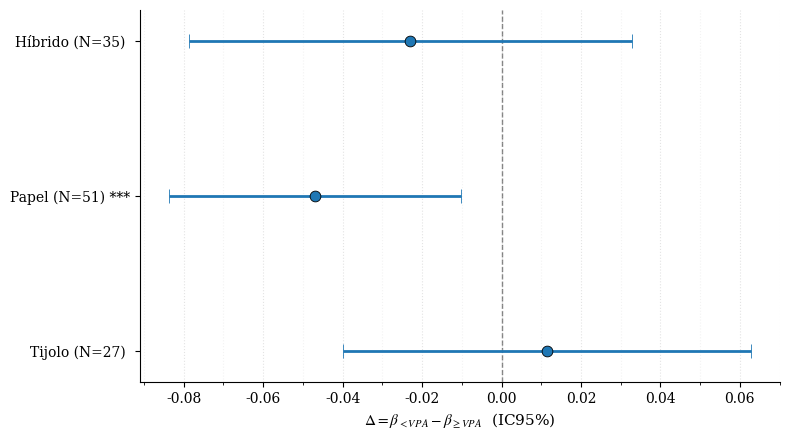


=== Diferença por grupo (Δ e IC95%, HC3) ===
  Grupo  N   Delta     SE       z     p1     p2  CI_low  CI_high
Híbrido 35 -0.0229 0.0284 -0.8066 0.2100 0.4199 -0.0787   0.0328
  Papel 51 -0.0469 0.0188 -2.4970 0.0063 0.0125 -0.0837  -0.0101
 Tijolo 27  0.0114 0.0262  0.4353 0.6683 0.6634 -0.0400   0.0628


In [ ]:
# Impacto econômico de emitir < VP (esperado NEGATIVO), três DVs:
tab_vc, model_vc = hetero_by_grupo_forest(
    base_canon, dv_col="Variacao_Capital_CAGR",
    diff="lt_minus_ge", alternative="less",
    plot_title="",
    use_times=True, times_mode="mpl"
)


=== Wald conjunto (robusto) — H0: sem heterogeneidade por grupo ===
chi2 = 13.637 | df = 4 | p = 0.0085


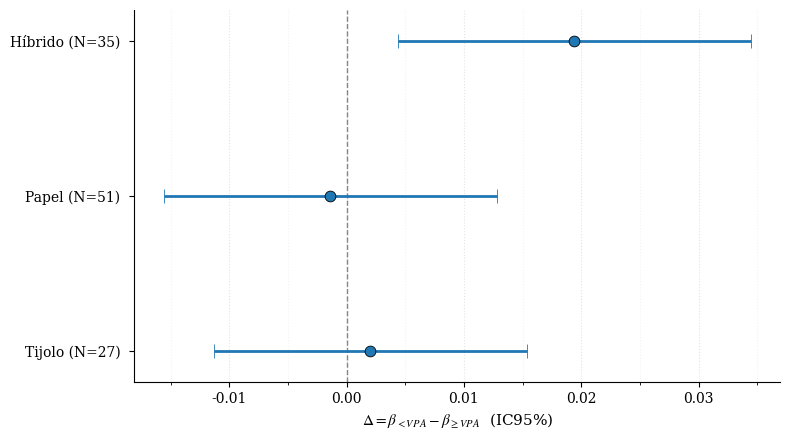


=== Diferença por grupo (Δ e IC95%, HC3) ===
  Grupo  N   Delta     SE       z     p1     p2  CI_low  CI_high
Híbrido 35  0.0194 0.0077  2.5345 0.9944 0.0113  0.0044   0.0344
  Papel 51 -0.0014 0.0072 -0.1910 0.4242 0.8485 -0.0156   0.0128
 Tijolo 27  0.0020 0.0068  0.2959 0.6164 0.7673 -0.0113   0.0154


In [ ]:
tab_dy, model_dy = hetero_by_grupo_forest(
    base_canon, dv_col="DY_anualizado",
    diff="lt_minus_ge", alternative="less",
    plot_title="",
    use_times=True, times_mode="mpl"
)


=== Wald conjunto (robusto) — H0: sem heterogeneidade por grupo ===
chi2 = 9.744 | df = 4 | p = 0.0450


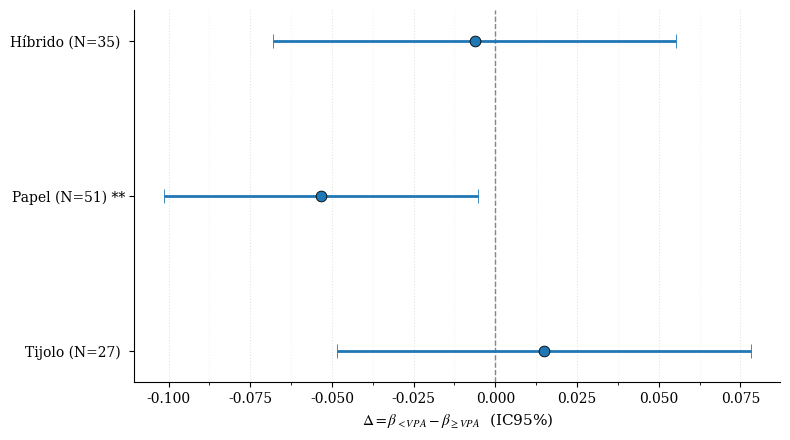


=== Diferença por grupo (Δ e IC95%, HC3) ===
  Grupo  N   Delta     SE       z     p1     p2  CI_low  CI_high
Híbrido 35 -0.0063 0.0315 -0.2012 0.4203 0.8405 -0.0680   0.0553
  Papel 51 -0.0534 0.0245 -2.1773 0.0147 0.0295 -0.1014  -0.0053
 Tijolo 27  0.0148 0.0323  0.4585 0.6767 0.6466 -0.0485   0.0781


In [ ]:
tab_rt, model_rt = hetero_by_grupo_forest(
    base_canon, dv_col="Retorno_Total_CAGR_composto",
    diff="lt_minus_ge", alternative="less",
    plot_title="",
    use_times=True, times_mode="mpl"
)


=== Wald conjunto (robusto) — H0: sem heterogeneidade por grupo ===
chi2 = 1.220 | df = 4 | p = 0.8747


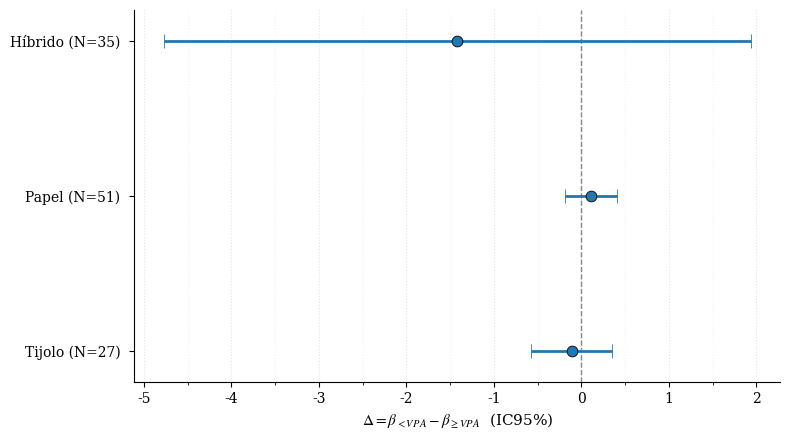


=== Diferença por grupo (Δ e IC95%, HC3) ===
  Grupo  N   Delta     SE       z     p1     p2  CI_low  CI_high
Híbrido 35 -1.4181 1.7107 -0.8289 0.2036 0.4071 -4.7711   1.9349
  Papel 51  0.1093 0.1504  0.7270 0.7664 0.4672 -0.1854   0.4041
 Tijolo 27 -0.1123 0.2341 -0.4798 0.3157 0.6314 -0.5712   0.3465


In [ ]:
tab_rt, model_rt = hetero_by_grupo_forest(
    base_canon, dv_col="Volatilidade_anualizada",
    diff="lt_minus_ge", alternative="less",
    plot_title="",
    use_times=True, times_mode="mpl"
)

# Tabelas Consolidadas

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# =========================
# Helpers de formatação
# =========================
def star(p):
    return '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''

def fmt(x, k=3):
    try:
        return f"{float(x):.{k}f}"
    except Exception:
        return ""

def robust_F_wald(res):
    """F robusto tipo Wald para todos os coeficientes (exceto intercepto)."""
    try:
        k = len(res.params)
        names = list(res.params.index)
        keep = [i for i, n in enumerate(names) if n != 'const']
        R = np.eye(k)[keep, :]
        wt = res.wald_test(R, use_f=True)  # usa a covariância robusta do modelo (HC3)
        return float(wt.fvalue), int(wt.df_num), int(wt.df_denom), float(wt.pvalue)
    except Exception:
        # fallback (nem sempre df robustos estão disponíveis)
        return float(res.fvalue), int(res.df_model), int(res.df_resid), float(res.f_pvalue)

# rótulos amigáveis (cobre variações de nomes)
VAR_LABELS = {
    "z_log_MC": "MarketCap",
    "z_log_LIQ": "Liquidez",
    "TaxaAdm_log1p_z": "Taxa Adm",
    "QtdAtivos_log1p_z": "Qtd. Ativos",
    "Alav_pos": "Alavancado",
    "Alav_level_z": "Alavancagem",
    'Vacancia_log1p_z': "Vacância",
    "D_Emitiu_acimaOuIgual_VP": "Emitiu ≥ VP",
    "D_Emitiu_abaixo_VP": "Emitiu < VP",
    "Perf_Sim": "Taxa de Performance = Sim",
    "Possui_Taxa_Performance_inicial_Sim": "Taxa de Performance = Sim",
    "const": "Intercepto",
}

def nice_label(varname: str) -> str:
    if varname in VAR_LABELS:
        return VAR_LABELS[varname]
    if varname.startswith("Segmento_Atuacao_inicial_"):
        seg = varname.replace("Segmento_Atuacao_inicial_", "")
        return f"Segmento: {seg}"
    return varname

# Ordem básica de exibição (faltantes são colocadas ao fim)
BASE_ORDER = [
    "z_log_MC","z_log_LIQ","TaxaAdm_log1p_z","QtdAtivos_log1p_z",
    "Alav_pos","Alav_level_z", 'Vacancia_log1p_z',
    "D_Emitiu_acimaOuIgual_VP","D_Emitiu_abaixo_VP",
    "Perf_Sim","Possui_Taxa_Performance_inicial_Sim"
]

def build_reg_table_from_models(models_dict, digits=3, title=None):
    # junta nomes de variáveis presentes em qualquer modelo
    varset = set()
    for res in models_dict.values():
        varset |= set(res.params.index)

    # põe segmentos após os controles principais
    segs = sorted([v for v in varset if v.startswith("Segmento_Atuacao_inicial_")])
    var_order = [v for v in BASE_ORDER if v in varset] + segs + (["const"] if "const" in varset else [])

    cols = []
    for colname, res in models_dict.items():
        s = {}
        for v in var_order:
            if v in res.params.index:
                b, se, p = res.params[v], res.bse[v], res.pvalues[v]
                s[nice_label(v)] = f"{fmt(b,digits)}{star(p)}\n({fmt(se,digits)})"
            else:
                s[nice_label(v)] = ""
        F, df1, df2, pF = robust_F_wald(res)
        s["Observações"] = f"{int(res.nobs)}"
        s["R²"] = fmt(res.rsquared, digits)
        s["R² ajustado"] = fmt(res.rsquared_adj, digits)
        s["Estatística F (robusta)"] = f"{fmt(F,digits)}{star(pF)}"
        s["gl F (num; den)"] = f"({df1}; {df2})"
        cols.append(pd.Series(s, name=colname))
    tab = pd.concat(cols, axis=1)

    if title:
        print("\n" + title)
    print("\nNotas: erros-padrão HC3 entre parênteses; * p<0.10, ** p<0.05, *** p<0.01.")
    with pd.option_context('display.width', 140, 'display.max_rows', 200):
        print(tab.to_string())
    return tab

def penalty_summary_from_models(models_dict, digits=4):
    """Δ = β(<VP) − β(≥VP), H1: Δ < 0 (p únicaudal)."""
    rows = []
    for name, res in models_dict.items():
        names = list(res.params.index)
        L = np.zeros((1, len(names)))
        if "D_Emitiu_abaixo_VP" in names:
            L[0, names.index("D_Emitiu_abaixo_VP")] = 1.0
        if "D_Emitiu_acimaOuIgual_VP" in names:
            L[0, names.index("D_Emitiu_acimaOuIgual_VP")] = -1.0

        diff = float(L @ res.params.values)
        V = res.cov_params().values
        se = float(np.sqrt(L @ V @ L.T))
        z = diff / se if se > 0 else np.nan
        p_two = 2 * (1 - stats.norm.cdf(abs(z))) if np.isfinite(z) else np.nan
        p_left = stats.norm.cdf(z) if np.isfinite(z) else np.nan  # H1: Δ < 0

        rows.append({
            "Modelo": name,
            "Δ = β(<VP) − β(≥VP)": round(diff, digits),
            "SE(HC3)": round(se, digits),
            "z": round(z, digits),
            "p (2 caudas)": round(p_two, digits),
            "p (1 cauda, H1: < 0)": round(p_left, digits),
            "IC95% inf": round(diff - 1.96*se, digits),
            "IC95% sup": round(diff + 1.96*se, digits),
        })
    df_pen = pd.DataFrame(rows)
    with pd.option_context('display.width', 140, 'display.max_rows', 200):
        print("\nPenalidade por emitir abaixo do VP (Δ = β<b> − β≥b), teste únicaudal H1: Δ < 0")
        print(df_pen.to_string(index=False))
    return df_pen

# =========================
# Usa diretamente seus modelos já estimados
# =========================
models_4 = {
    "Var. Capital (CAGR)": m_adj_hc3,
    "Dividend Yield":      m_dy_hc3,
    "Retorno Total":       m_retorno,
    "Volatilidade":        m_vol,
}

tabela_4dv = build_reg_table_from_models(models_4, digits=3,
                                         title="Tabela — Modelo 2 (HC3) com quatro desfechos")
penal_4dv  = penalty_summary_from_models(models_4, digits=4)

# (Opcional) exportar LaTeX/CSV
# tabela_4dv.to_latex("tabela_modelo2_4dv.tex", escape=False)
# penal_4dv.to_csv("penalidade_modelo2_4dv.csv", index=False)



Tabela — Modelo 2 (HC3) com quatro desfechos

Notas: erros-padrão HC3 entre parênteses; * p<0.10, ** p<0.05, *** p<0.01.
                              Var. Capital (CAGR)      Dividend Yield       Retorno Total     Volatilidade
MarketCap                         -0.002\n(0.009)      0.002\n(0.005)     -0.000\n(0.011)  -0.356\n(0.534)
Liquidez                        -0.017**\n(0.007)     -0.007\n(0.006)   -0.026**\n(0.010)   0.042\n(0.382)
Taxa Adm                         -0.028*\n(0.014)     -0.004\n(0.009)     -0.033\n(0.023)   0.001\n(0.102)
Qtd. Ativos                        0.006\n(0.012)      0.003\n(0.003)      0.009\n(0.015)  -0.046\n(0.104)
Alavancado                         0.000\n(0.014)     0.006*\n(0.004)      0.006\n(0.016)   0.047\n(0.103)
Alavancagem                       -0.016\n(0.015)     -0.001\n(0.004)     -0.019\n(0.017)   0.004\n(0.087)
Vacância                         -0.013*\n(0.008)  -0.005***\n(0.002)   -0.019**\n(0.009)   0.011\n(0.058)
Emitiu ≥ VP           

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipython-input-190981071.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(wt.fvalue), int(wt.df_num), int(wt.df_denom), float(wt.pvalue)
/tmp/ipython-input-190981071.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  diff = float(L @ res.params.values)
/tmp/ipython-input-190981071.py:110: De

In [ ]:
# ======== GERE IMAGEM LATEX BONITA DAS TABELAS (COLAB-READY) ========
import os, re, shutil, subprocess
from pathlib import Path

# -------- helpers LaTeX --------
def _latex_escape(s: str) -> str:
    if s is None:
        return ""
    s = str(s)
    # trocar símbolos “≥” por \geq para compatibilidade
    s = s.replace("≥", r"$\geq$")
    # quebra de linha dentro da célula -> makecell
    s = s.replace("\n", r"\\")
    # escapar caracteres LaTeX sensíveis (menos % * () que usamos em SE/estrelas)
    s = (s.replace("&", r"\&")
           .replace("#", r"\#")
           .replace("_", r"\_"))
    return s

def _latex_tabular_from_df(df, title="Resultados de Regressão", note="Erros-padrão HC3 entre parênteses; * p<0,10 ** p<0,05 *** p<0,01.", label="tab:resultados", font_size="\\footnotesize"):
    cols = list(df.columns)
    aligns = "l" + "c"*len(cols)
    header_cols = " & ".join([_latex_escape(c) for c in cols]) + r" \\"

    lines = []
    for idx, row in df.iterrows():
        rname = _latex_escape(str(idx))
        cells = []
        for c in cols:
            val = "" if pd.isna(row[c]) else str(row[c])
            cell = r"\makecell{" + _latex_escape(val) + "}"
            cells.append(cell)
        lines.append(rname + " & " + " & ".join(cells) + r" \\")
    body = "\n".join(lines)

    tex = rf"""
\documentclass[varwidth]{{standalone}}
\usepackage[utf8]{{inputenc}}
\usepackage[T1]{{fontenc}}
\usepackage{{booktabs,threeparttable,makecell,siunitx}}
\usepackage{{lmodern}}
\renewcommand\theadfont{{\normalsize\bfseries}}
\renewcommand\cellalign{{lc}}
\renewcommand\cellgape{{\Gape[3pt]}}
\renewcommand{{\arraystretch}}{{1.2}}

\begin{{document}}
{font_size}
\begin{{threeparttable}}
\caption{{{_latex_escape(title)}}}
\label{{{_latex_escape(label)}}}
\begin{{tabular}}{{{aligns}}}
\toprule
 & {header_cols}
\\ \midrule
{body}
\\ \bottomrule
\end{{tabular}}
\begin{{tablenotes}}[flushleft]
\item \scriptsize { _latex_escape(note) }
\end{{tablenotes}}
\end{{threeparttable}}
\end{{document}}
"""
    return tex

def _write_tex(tex_str: str, path: str):
    Path(path).write_text(tex_str, encoding="utf-8")
    print(f"Arquivo .tex salvo em: {path}")

def _ensure_bin(bin_name: str, apt_pkgs=None):
    """Tenta garantir binário (Colab)."""
    if shutil.which(bin_name) is not None:
        return True
    if apt_pkgs is None:
        return False
    try:
        print(f"Instalando {bin_name} via apt (pode demorar alguns minutos)...")
        subprocess.run(["apt-get","update","-qq"], check=True)
        subprocess.run(["apt-get","install","-y","-qq"] + apt_pkgs, check=True)
        return shutil.which(bin_name) is not None
    except Exception as e:
        print(f"Falhou instalar {bin_name}: {e}")
        return False

def compile_tex_to_png(tex_path: str, out_prefix: str=None):
    """Compila o .tex em PDF e PNG. Requer pdflatex e pdftoppm."""
    tex_path = str(tex_path)
    workdir = str(Path(tex_path).parent)
    stem = Path(tex_path).stem
    out_prefix = out_prefix or os.path.join(workdir, stem)

    ok_pdf = _ensure_bin("pdflatex", ["texlive-latex-extra", "texlive-fonts-recommended", "texlive-latex-recommended"])
    ok_ppm = _ensure_bin("pdftoppm", ["poppler-utils"])

    if not ok_pdf or not ok_ppm:
        print("Aviso: não foi possível garantir pdflatex/pdftoppm. Copie o .tex para o Overleaf, ou instale manualmente.")
        return None, None

    # compila duas vezes por segurança
    for _ in range(2):
        subprocess.run(["pdflatex","-interaction=nonstopmode", tex_path], cwd=workdir, check=True, stdout=subprocess.DEVNULL)

    pdf_path = os.path.join(workdir, f"{stem}.pdf")
    png_path = os.path.join(workdir, f"{stem}.png")
    subprocess.run(["pdftoppm","-png","-singlefile",pdf_path,out_prefix], cwd=workdir, check=True)
    if os.path.exists(png_path):
        print(f"PNG gerado: {png_path}")
    else:
        print(f"Saída PNG esperada em: {out_prefix}.png")
    return pdf_path, png_path

# -------- 1) GERAR TABELA PRINCIPAL (4 desfechos) --------
titulo_main = "Modelo 2 (HC3) — Quatro variáveis dependentes"
nota_main = "Erros-padrão HC3 entre parênteses; * p<0,10 ** p<0,05 *** p<0,01. Referências: Segmento=‘Outros’; TaxaPerf=‘Não’."
tex_main = _latex_tabular_from_df(tabela_4dv, title=titulo_main, note=nota_main, label="tab:modelo2_4dv")
tex_main_path = "/content/tabela_modelo2_4dv.tex"
_write_tex(tex_main, tex_main_path)

# (opcional) compilar para PDF/PNG
# compile_tex_to_png(tex_main_path)

# -------- 2) GERAR TABELA DA PENALIDADE (Δ = β(<VP) − β(≥VP)) --------
# Formatar a penalidade com casas e estrelinhas no p únicaudal (H1: Δ<0)
penal_pretty = penal_4dv.copy()
def _stars_from_p(p):
    try:
        p = float(p)
    except:
        return ""
    return "***" if p < 0.01 else "**" if p < 0.05 else "*" if p < 0.10 else ""

penal_pretty["p (1 cauda, H1: < 0)"] = penal_pretty["p (1 cauda, H1: < 0)"].astype(float)
penal_pretty["Sig."] = penal_pretty["p (1 cauda, H1: < 0)"].apply(_stars_from_p)
penal_pretty = penal_pretty[["Modelo","Δ = β(<VP) − β(≥VP)","SE(HC3)","z","p (1 cauda, H1: < 0)","IC95% inf","IC95% sup","Sig."]]
penal_pretty = penal_pretty.set_index("Modelo")

titulo_pen = "Penalidade por emitir abaixo do VP — Δ = β(<VP) − β(≥VP) (teste únicaudal)"
nota_pen = "Valores negativos (com * / ** / ***) indicam pior desempenho ao emitir abaixo do VP; * p<0,10 ** p<0,05 *** p<0,01."
tex_pen = _latex_tabular_from_df(penal_pretty, title=titulo_pen, note=nota_pen, label="tab:penalidade", font_size="\\small")
tex_pen_path = "/content/tabela_penalidade.tex"
_write_tex(tex_pen, tex_pen_path)

# (opcional) compilar para PDF/PNG
# compile_tex_to_png(tex_pen_path)


Arquivo .tex salvo em: /content/tabela_modelo2_4dv.tex
Arquivo .tex salvo em: /content/tabela_penalidade.tex
